In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA

import nltk
import gensim
import pickle

from collections import Counter
import warnings 
warnings.filterwarnings("ignore")

2023-07-19 23:52:18.493327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Helper Functions

In [2]:
#Pulled from homework 9
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

def limit_vocab(sequences, max_token_id):
  """Replace token ids greater than or equal to max_token_id to the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = max_token_id
  return reduced_sequences

def plot_loss_accuracy(history):
    
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    ax.set_ylim(0,1)
    plt.show()
    
def reduce_vocab(X_train_padded, X_val_padded, X_test_padded, n):
    X_train_reduced = limit_vocab(X_train_padded, n + 1)
    X_val_reduced = limit_vocab(X_val_padded, n + 1)
    X_test_reduced = limit_vocab(X_test_padded, n + 1)
    return X_train_reduced, X_val_reduced, X_test_reduced

### CUSTOM FUNCTION 
def train_embedding(vocab_size, embedding_output_dim, X_train_reduced, y_train, 
                    hidden_layers = [], epochs = 10, random_state = 1234):
    '''
    Function to generalize embedding training, allowing different parameters to be passed in 
    to try training embeddings model
    
    Inputs:
        vocab_size (int): size of total vocabulary
        embedding_output_dim (int): size of the embedding vector to output from Embedding layer 
        X_train_reduced (array): training data to train model, should be data that is 
                                padded, encoded, and reduced down to vocab size 
        y_train (array): test data to train model
        hidden_layer (list): list of nodes to use for each new layer in neural network 
        epochs (int): number of training iterations 
        random_state (int): set random state for reproducibility
    Outputs
        history (tensorflow history): training history 
    
    '''
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_state)
    #Add early stopping to prevent extreme overfitting
    #If validation loss hasn't improved in 3 iterations, stop training 
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) 
    
    model = tf.keras.Sequential()
    #Add Embedding layer
    model.add(tf.keras.layers.Embedding(input_dim = vocab_size + 2, #Add 2 for padding and unknown tokens
                                       output_dim = embedding_output_dim))
    #Take average of output
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    
    #Add more layers to neural network, each input in hidden_layer is additional layer 
    for nodes in hidden_layers:
        model.add(tf.keras.layers.Dense(nodes, activation = "relu"))
        model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

    model.compile(loss = "binary_crossentropy",
             optimizer = "adam", 
             metrics = ["accuracy"])
    
    #Fit the training and test dataset 
    tf.random.set_seed(random_state)
    np.random.seed(random_state)
    history = model.fit(
        x = X_train_reduced,
        y = y_train,
        validation_split=0.2, 
        epochs=epochs, 
        callbacks=[callback])
    
    return history 

## Read in Data and Split

In [4]:
df = pd.read_pickle("Cleaned Suicide Detection 2023-07-08.pkl")
#convert output to numeric
df["class"] = df["class"].apply(lambda x: 1 if x == "suicide" else 0)

In [5]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text_cleaned'], df['class'], test_size=0.2, random_state=42)

# Further split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

print("Train\n", X_train.head(5))


print("\nValidation\n", X_val.head(5))


print("\nTest\n", X_test.head(5))


(139243,) (46415,) (46415,)
Train
 64811            salmon ling platoon trailer want pet right
26585     anyone geddit trouble logging geddit christ se...
87417     feeling silence think let suicide day born kne...
212624    autism valid reason kill autistic woman nobody...
56128     wish cowardice tendency end life think little ...
Name: text_cleaned, dtype: object

Validation
 30466     done shit come lesbian gay bisexual transsexua...
220635    dying scared always thought ending college fac...
135297    need advice hello life bad happy couple friend...
55524     hey everybody need editor help guy friend kind...
158304    want work anymore depressed suicidal decade ne...
Name: text_cleaned, dtype: object

Test
 74414     month harm free urge get every day day shit si...
149516    start becoming rich start company become affor...
12484     poem haiku game dev hello hello stop fucking s...
14043     honestly got no idea anymore feel everyone fak...
30673     ever cry think unfair life 

## Tokenization, Padding, and Reduction

In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)
#Give 2 extra for padding and for unknown words
vocab_size = len(tokenizer.word_index) + 2
print(vocab_size)
#Convert text to numeric index of words
X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_val_encoded = tokenizer.texts_to_sequences(X_val)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

57402


In [10]:
print(pd.Series(X_train_encoded).apply(lambda x: len(x)).max())
print(pd.Series(X_train_encoded).apply(lambda x: len(x)).quantile(0.86))

5715
100.0


In [11]:
#100 words equate to about a paragraph, likely able to distinguish what class after a paragraph
#86% of text is 100 words or less, limit and pad text to 100 tokens 
X_train_padded = pad_data(X_train_encoded, 100)
X_val_padded = pad_data(X_val_encoded, 100)
X_test_padded = pad_data(X_test_encoded, 100)

In [12]:
#vocab size is almost 60k, want to limit space for faster computation 
#Want to take around 10k/5k/2.5k words, which translates to words that have at least 25/100/300 instances
print((pd.Series(tokenizer.word_counts) >= 25).sum())
print((pd.Series(tokenizer.word_counts) >= 100).sum())
print((pd.Series(tokenizer.word_counts) >= 300).sum())

10017
4843
2473


In [13]:
index = 2473
print("word:", tokenizer.index_word[index])
print("count:", tokenizer.word_counts[tokenizer.index_word[index]])

word: ease
count: 300


In [14]:
#10,017 word is blank, doesn't give information about the classes at that point, 
#take first 10,016 token, convert everything else to 10,017
X_train_reduced1, X_val_reduced1, X_test_reduced1 = reduce_vocab(X_train_padded, X_val_padded, X_test_padded, 10016)
X_train_reduced2, X_val_reduced2, X_test_reduced2 = reduce_vocab(X_train_padded, X_val_padded, X_test_padded, 4843)
X_train_reduced3, X_val_reduced3, X_test_reduced3 = reduce_vocab(X_train_padded, X_val_padded, X_test_padded, 2473)


In [191]:
# with open('word_embeddings_tokenizer.pkl', 'wb') as handle:
#     pickle.dump(tokenizer, handle)

## Embedding Model

Train different vocabulary sizes, output dimensions, number of hidden layers

### Vocab Size = 10k, No Hidden Layer

Epoch 1/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.3521 - accuracy: 0.8535 - val_loss: 0.2562 - val_accuracy: 0.9008
Epoch 2/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2289 - accuracy: 0.9171 - val_loss: 0.2327 - val_accuracy: 0.9165
Epoch 3/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2090 - accuracy: 0.9252 - val_loss: 0.2292 - val_accuracy: 0.9155
Epoch 4/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.1989 - accuracy: 0.9292 - val_loss: 0.2274 - val_accuracy: 0.9186
Epoch 5/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.1921 - accuracy: 0.9319 - val_loss: 0.2292 - val_accuracy: 0.9174
Epoch 6/10
3482/3482 [==============================] - 16s 5ms/step - loss: 0.1869 - accuracy: 0.9335 - val_loss: 0.2316 - val_accuracy: 0.9219
Epoch 7/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.1828 - accuracy: 0.9350 - val_loss: 0.2330 - val_ac

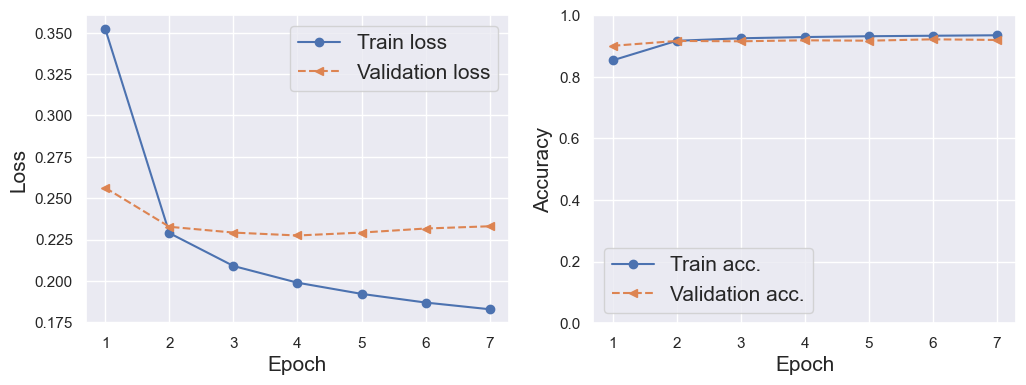

In [69]:
#10k vocab size, 25 output embedding, no hidden layer 
history_1_1 = train_embedding(vocab_size = 10016, 
                          embedding_output_dim = 25,
                          X_train_reduced = X_train_reduced1,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_1_1)

Epoch 1/10
3482/3482 [==============================] - 27s 7ms/step - loss: 0.3221 - accuracy: 0.8695 - val_loss: 0.2432 - val_accuracy: 0.9062
Epoch 2/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2188 - accuracy: 0.9214 - val_loss: 0.2290 - val_accuracy: 0.9199
Epoch 3/10
3482/3482 [==============================] - 27s 8ms/step - loss: 0.2023 - accuracy: 0.9281 - val_loss: 0.2289 - val_accuracy: 0.9159
Epoch 4/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.1933 - accuracy: 0.9312 - val_loss: 0.2292 - val_accuracy: 0.9174
Epoch 5/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.1872 - accuracy: 0.9334 - val_loss: 0.2319 - val_accuracy: 0.9172
Epoch 6/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.1824 - accuracy: 0.9350 - val_loss: 0.2362 - val_accuracy: 0.9211


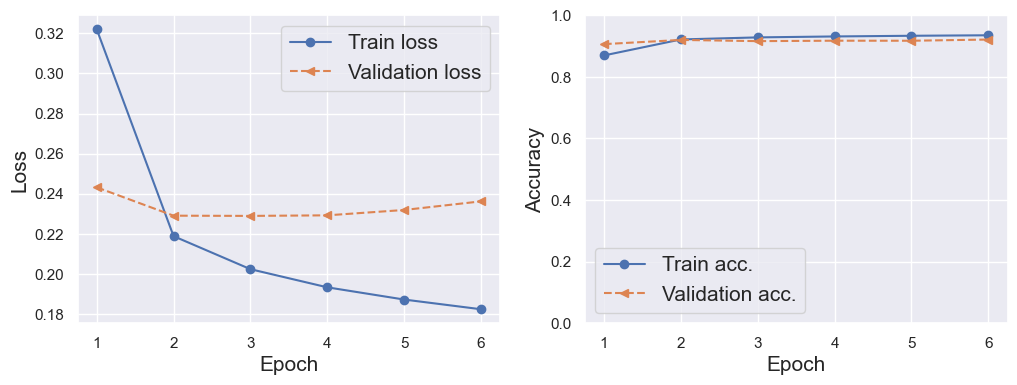

In [70]:
#10k vocab size, 50 output embedding, no hidden layer 
history_1_2 = train_embedding(vocab_size = 10016, 
                          embedding_output_dim = 50,
                          X_train_reduced = X_train_reduced1,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_1_2)

Epoch 1/10
3482/3482 [==============================] - 49s 14ms/step - loss: 0.2989 - accuracy: 0.8809 - val_loss: 0.2367 - val_accuracy: 0.9087
Epoch 2/10
3482/3482 [==============================] - 48s 14ms/step - loss: 0.2121 - accuracy: 0.9239 - val_loss: 0.2285 - val_accuracy: 0.9216
Epoch 3/10
3482/3482 [==============================] - 46s 13ms/step - loss: 0.1977 - accuracy: 0.9295 - val_loss: 0.2310 - val_accuracy: 0.9148
Epoch 4/10
3482/3482 [==============================] - 47s 13ms/step - loss: 0.1894 - accuracy: 0.9319 - val_loss: 0.2329 - val_accuracy: 0.9158
Epoch 5/10
3482/3482 [==============================] - 46s 13ms/step - loss: 0.1839 - accuracy: 0.9344 - val_loss: 0.2357 - val_accuracy: 0.9182


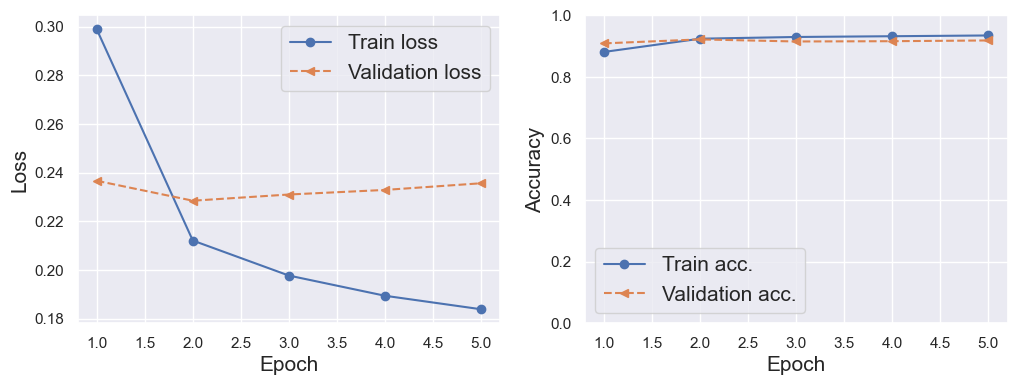

In [71]:
#10k vocab size, 25 output embedding, no hidden layer 
history_1_3 = train_embedding(vocab_size = 10016, 
                          embedding_output_dim = 100,
                          X_train_reduced = X_train_reduced1,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_1_3)

### Vocab size = 10k, 1 Hidden Layer

Epoch 1/10
3482/3482 [==============================] - 19s 5ms/step - loss: 0.2855 - accuracy: 0.8919 - val_loss: 0.2089 - val_accuracy: 0.9218
Epoch 2/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2049 - accuracy: 0.9271 - val_loss: 0.2054 - val_accuracy: 0.9233
Epoch 3/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.1906 - accuracy: 0.9325 - val_loss: 0.2125 - val_accuracy: 0.9209
Epoch 4/10
3482/3482 [==============================] - 20s 6ms/step - loss: 0.1801 - accuracy: 0.9346 - val_loss: 0.2161 - val_accuracy: 0.9207
Epoch 5/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.1726 - accuracy: 0.9374 - val_loss: 0.2204 - val_accuracy: 0.9224


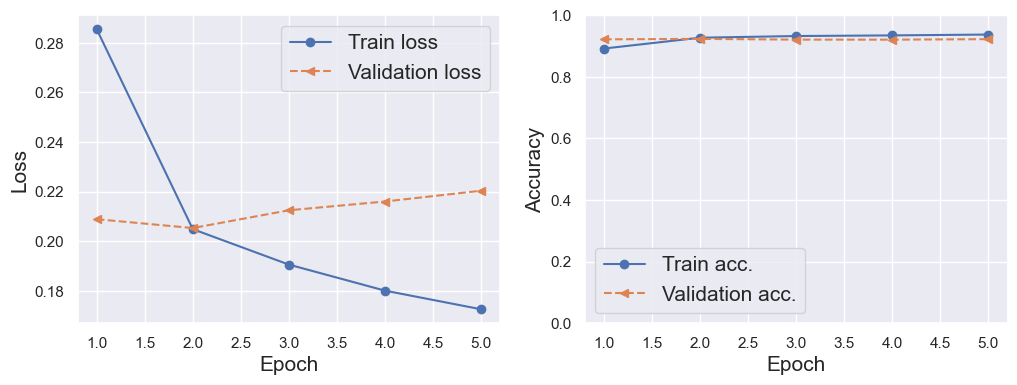

In [72]:
#10k vocab size, 25 output embedding, 1 hidden layer 
history_1_4 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 25,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_4)

Epoch 1/10
3482/3482 [==============================] - 28s 8ms/step - loss: 0.2594 - accuracy: 0.8999 - val_loss: 0.2057 - val_accuracy: 0.9208
Epoch 2/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.1927 - accuracy: 0.9291 - val_loss: 0.2025 - val_accuracy: 0.9240
Epoch 3/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.1787 - accuracy: 0.9339 - val_loss: 0.2238 - val_accuracy: 0.9148
Epoch 4/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.1668 - accuracy: 0.9372 - val_loss: 0.2137 - val_accuracy: 0.9226
Epoch 5/10
3482/3482 [==============================] - 27s 8ms/step - loss: 0.1576 - accuracy: 0.9393 - val_loss: 0.2248 - val_accuracy: 0.9224


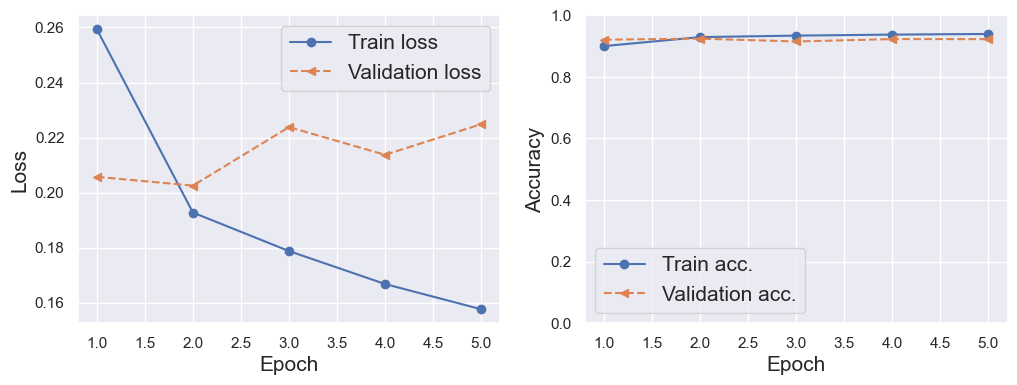

In [73]:
#10k vocab size, 50 output embedding, 1 hidden layer 
history_1_5 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_5)

Epoch 1/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.2763 - accuracy: 0.8960 - val_loss: 0.2058 - val_accuracy: 0.9227
Epoch 2/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2013 - accuracy: 0.9283 - val_loss: 0.2043 - val_accuracy: 0.9232
Epoch 3/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.1866 - accuracy: 0.9329 - val_loss: 0.2208 - val_accuracy: 0.9159
Epoch 4/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.1760 - accuracy: 0.9358 - val_loss: 0.2171 - val_accuracy: 0.9212
Epoch 5/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.1664 - accuracy: 0.9373 - val_loss: 0.2277 - val_accuracy: 0.9211


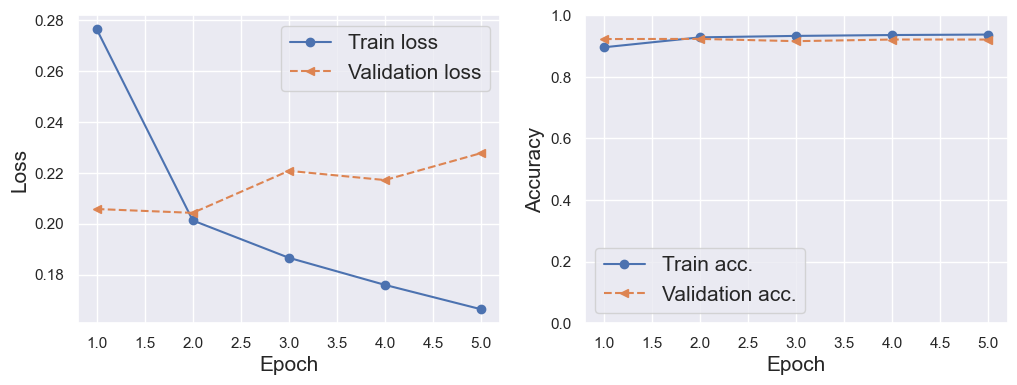

In [74]:
#10k vocab size, 50 output embedding, 1 hidden layer 
history_1_5_2 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_5_2)

Epoch 1/10
3482/3482 [==============================] - 49s 14ms/step - loss: 0.2401 - accuracy: 0.9070 - val_loss: 0.2047 - val_accuracy: 0.9204
Epoch 2/10
3482/3482 [==============================] - 47s 14ms/step - loss: 0.1846 - accuracy: 0.9298 - val_loss: 0.2040 - val_accuracy: 0.9232
Epoch 3/10
3482/3482 [==============================] - 47s 14ms/step - loss: 0.1677 - accuracy: 0.9356 - val_loss: 0.2430 - val_accuracy: 0.9057
Epoch 4/10
3482/3482 [==============================] - 49s 14ms/step - loss: 0.1566 - accuracy: 0.9396 - val_loss: 0.2199 - val_accuracy: 0.9225
Epoch 5/10
3482/3482 [==============================] - 47s 14ms/step - loss: 0.1460 - accuracy: 0.9437 - val_loss: 0.2340 - val_accuracy: 0.9213


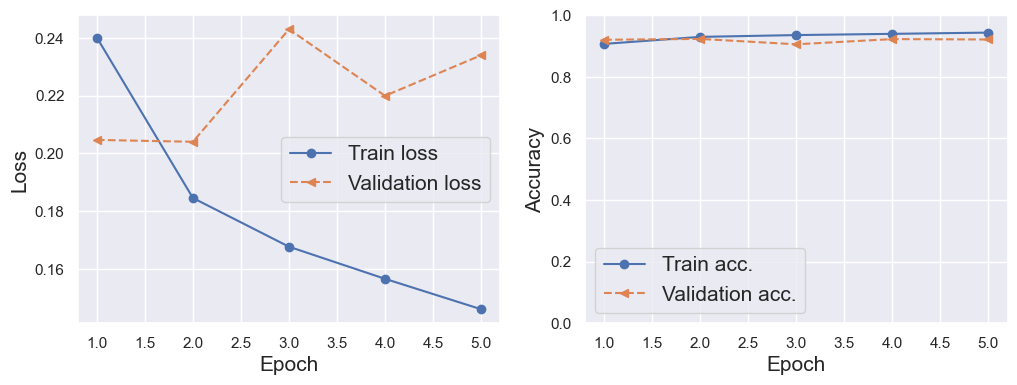

In [75]:
#10k vocab size, 100 output embedding, 1 hidden layer 
history_1_6 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [100],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_6)

Epoch 1/10
3482/3482 [==============================] - 49s 14ms/step - loss: 0.2509 - accuracy: 0.9033 - val_loss: 0.2045 - val_accuracy: 0.9210
Epoch 2/10
3482/3482 [==============================] - 49s 14ms/step - loss: 0.1899 - accuracy: 0.9294 - val_loss: 0.2045 - val_accuracy: 0.9230
Epoch 3/10
3482/3482 [==============================] - 40s 11ms/step - loss: 0.1731 - accuracy: 0.9345 - val_loss: 0.2292 - val_accuracy: 0.9136
Epoch 4/10
3482/3482 [==============================] - 40s 11ms/step - loss: 0.1626 - accuracy: 0.9380 - val_loss: 0.2188 - val_accuracy: 0.9224


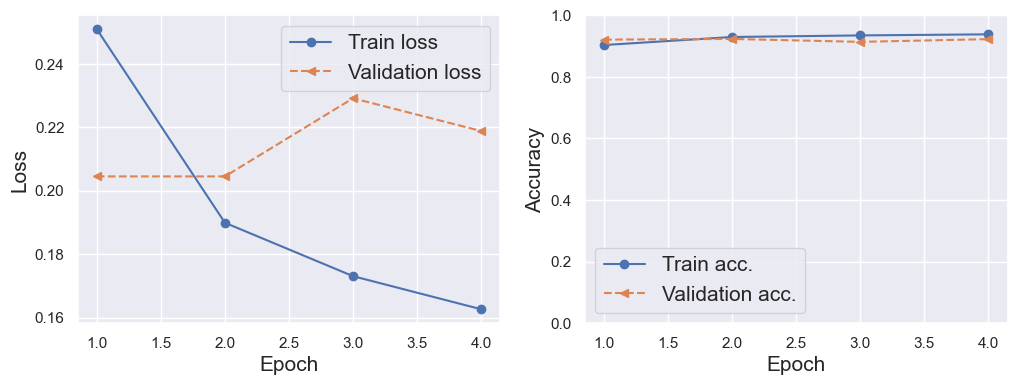

In [76]:
#10k vocab size, 50 output embedding, 1 hidden layer 
history_1_6_2 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_6_2)

### Vocab size = 10k, 2 Hidden Layers

Epoch 1/10
3482/3482 [==============================] - 16s 4ms/step - loss: 0.2966 - accuracy: 0.8924 - val_loss: 0.2058 - val_accuracy: 0.9220
Epoch 2/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.2203 - accuracy: 0.9251 - val_loss: 0.2079 - val_accuracy: 0.9213
Epoch 3/10
3482/3482 [==============================] - 20s 6ms/step - loss: 0.2047 - accuracy: 0.9288 - val_loss: 0.2206 - val_accuracy: 0.9178
Epoch 4/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1927 - accuracy: 0.9313 - val_loss: 0.2255 - val_accuracy: 0.9209


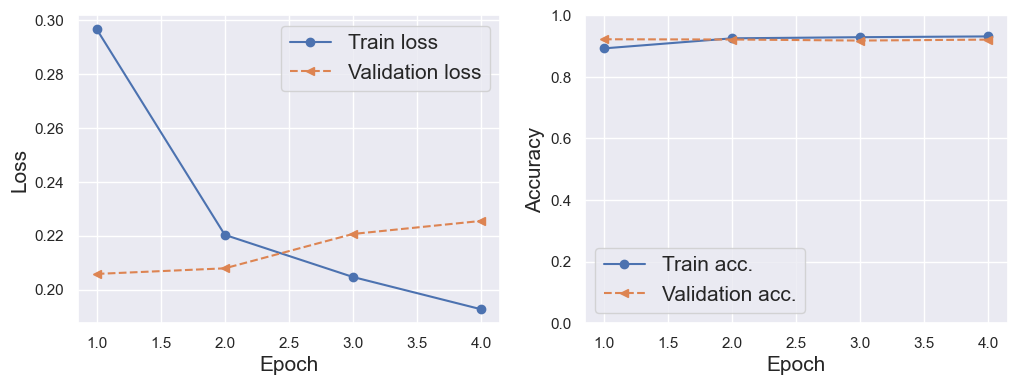

In [77]:
#10k vocab size, 25 output embedding, 1 hidden layer 
history_1_7 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 25,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_7)

Epoch 1/10
3482/3482 [==============================] - 23s 6ms/step - loss: 0.2630 - accuracy: 0.9023 - val_loss: 0.2086 - val_accuracy: 0.9219
Epoch 2/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.2022 - accuracy: 0.9286 - val_loss: 0.2062 - val_accuracy: 0.9238
Epoch 3/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1854 - accuracy: 0.9329 - val_loss: 0.2338 - val_accuracy: 0.9123
Epoch 4/10
3482/3482 [==============================] - 21s 6ms/step - loss: 0.1740 - accuracy: 0.9362 - val_loss: 0.2196 - val_accuracy: 0.9222
Epoch 5/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1647 - accuracy: 0.9385 - val_loss: 0.2393 - val_accuracy: 0.9220


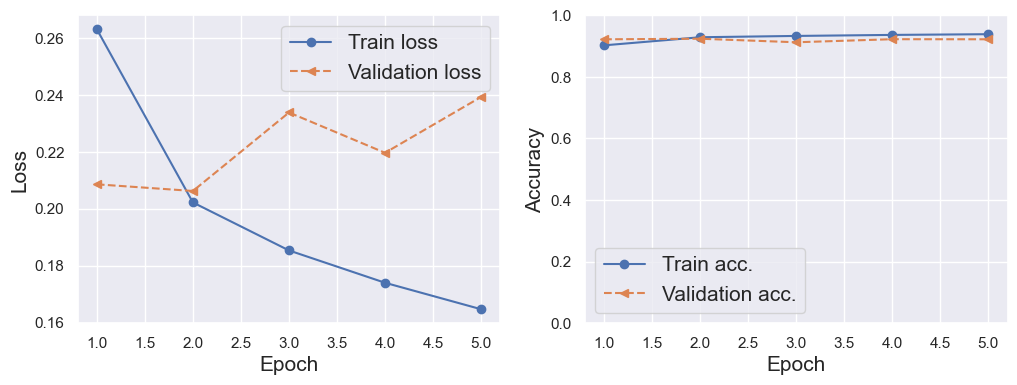

In [78]:
#10k vocab size, 25 output embedding, 1 hidden layer 
history_1_8 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [50, 25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_8)

Epoch 1/10
3482/3482 [==============================] - 23s 6ms/step - loss: 0.2940 - accuracy: 0.8935 - val_loss: 0.2085 - val_accuracy: 0.9221
Epoch 2/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.2216 - accuracy: 0.9244 - val_loss: 0.2089 - val_accuracy: 0.9229
Epoch 3/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.2052 - accuracy: 0.9289 - val_loss: 0.2125 - val_accuracy: 0.9230
Epoch 4/10
3482/3482 [==============================] - 21s 6ms/step - loss: 0.1931 - accuracy: 0.9317 - val_loss: 0.2294 - val_accuracy: 0.9160


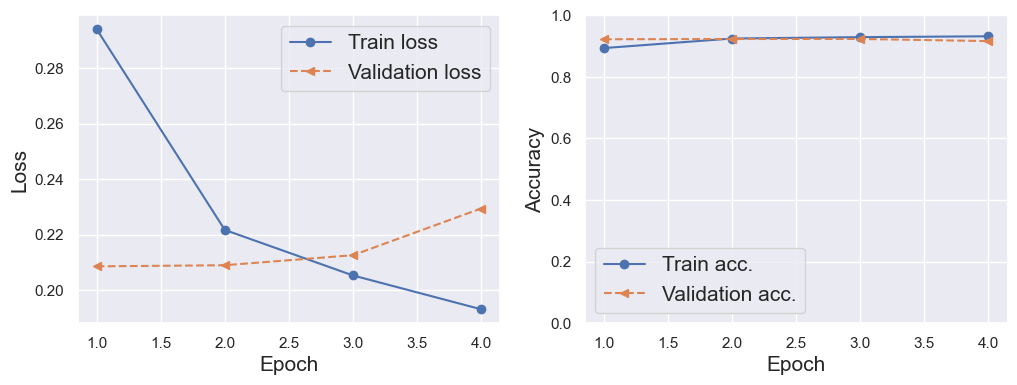

In [79]:
#10k vocab size, 25 output embedding, 1 hidden layer 
history_1_8_2 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_8_2)

Epoch 1/10
3482/3482 [==============================] - 40s 11ms/step - loss: 0.2435 - accuracy: 0.9072 - val_loss: 0.2086 - val_accuracy: 0.9202
Epoch 2/10
3482/3482 [==============================] - 40s 11ms/step - loss: 0.1905 - accuracy: 0.9294 - val_loss: 0.2052 - val_accuracy: 0.9232
Epoch 3/10
3482/3482 [==============================] - 39s 11ms/step - loss: 0.1708 - accuracy: 0.9363 - val_loss: 0.2446 - val_accuracy: 0.9062
Epoch 4/10
3482/3482 [==============================] - 40s 11ms/step - loss: 0.1576 - accuracy: 0.9412 - val_loss: 0.2205 - val_accuracy: 0.9239
Epoch 5/10
3482/3482 [==============================] - 39s 11ms/step - loss: 0.1451 - accuracy: 0.9455 - val_loss: 0.2548 - val_accuracy: 0.9120


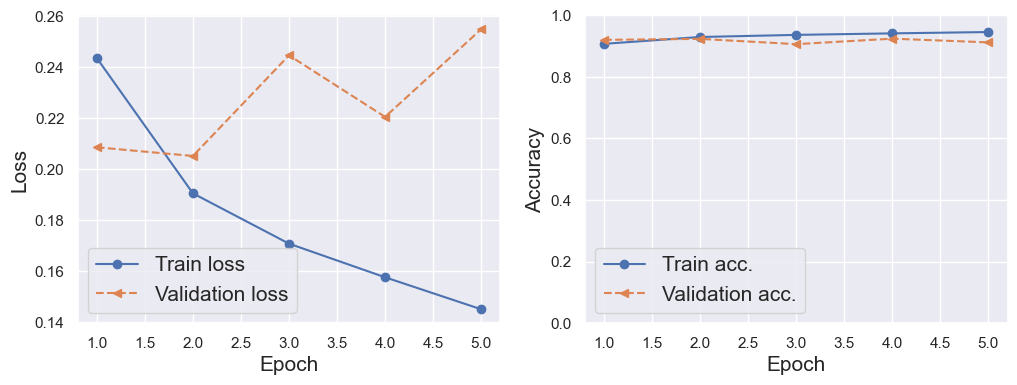

In [80]:
#10k vocab size, 25 output embedding, 1 hidden layer 
history_1_9 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [100, 50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_9)

Epoch 1/10
3482/3482 [==============================] - 41s 11ms/step - loss: 0.2605 - accuracy: 0.9032 - val_loss: 0.2043 - val_accuracy: 0.9232
Epoch 2/10
3482/3482 [==============================] - 41s 12ms/step - loss: 0.2016 - accuracy: 0.9279 - val_loss: 0.2064 - val_accuracy: 0.9234
Epoch 3/10
3482/3482 [==============================] - 40s 12ms/step - loss: 0.1841 - accuracy: 0.9327 - val_loss: 0.2304 - val_accuracy: 0.9129
Epoch 4/10
3482/3482 [==============================] - 39s 11ms/step - loss: 0.1718 - accuracy: 0.9372 - val_loss: 0.2225 - val_accuracy: 0.9232


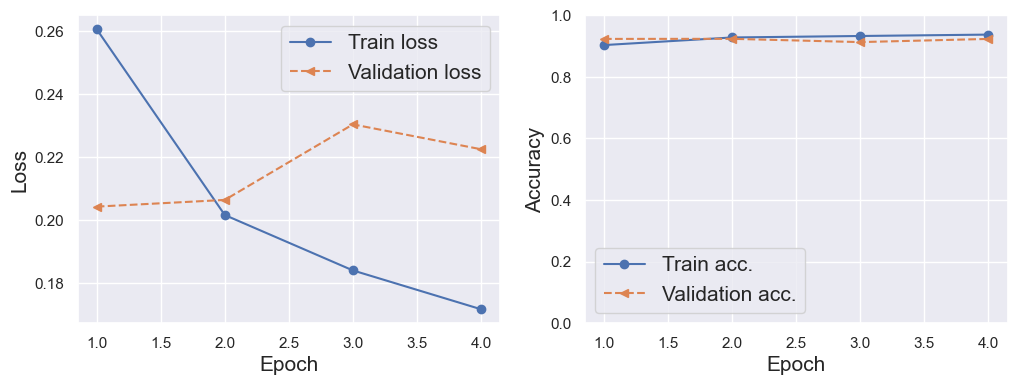

In [81]:
#10k vocab size, 25 output embedding, 1 hidden layer 
history_1_9_2 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [50, 25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_9_2)

Epoch 1/10
3482/3482 [==============================] - 43s 12ms/step - loss: 0.3061 - accuracy: 0.8937 - val_loss: 0.2188 - val_accuracy: 0.9195
Epoch 2/10
3482/3482 [==============================] - 40s 12ms/step - loss: 0.2349 - accuracy: 0.9177 - val_loss: 0.2201 - val_accuracy: 0.9213
Epoch 3/10
3482/3482 [==============================] - 40s 11ms/step - loss: 0.2148 - accuracy: 0.9222 - val_loss: 0.2376 - val_accuracy: 0.9111
Epoch 4/10
3482/3482 [==============================] - 40s 11ms/step - loss: 0.2008 - accuracy: 0.9269 - val_loss: 0.2314 - val_accuracy: 0.9178


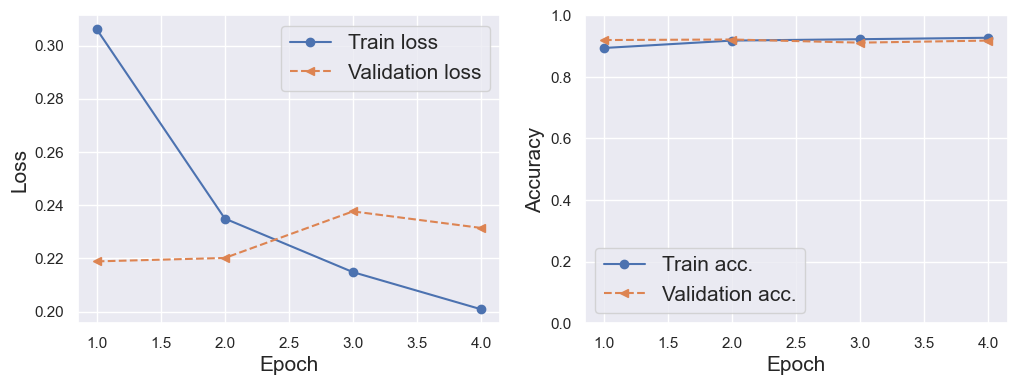

In [82]:
#10k vocab size, 25 output embedding, 1 hidden layer 
history_1_9_3 = train_embedding(vocab_size = 10016, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced1,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_1_9_3)

### Vocab size = 5k, No Hidden Layers

Epoch 1/10
3482/3482 [==============================] - 13s 3ms/step - loss: 0.3497 - accuracy: 0.8547 - val_loss: 0.2572 - val_accuracy: 0.9001
Epoch 2/10
3482/3482 [==============================] - 11s 3ms/step - loss: 0.2321 - accuracy: 0.9156 - val_loss: 0.2349 - val_accuracy: 0.9149
Epoch 3/10
3482/3482 [==============================] - 12s 3ms/step - loss: 0.2147 - accuracy: 0.9232 - val_loss: 0.2322 - val_accuracy: 0.9137
Epoch 4/10
3482/3482 [==============================] - 12s 3ms/step - loss: 0.2068 - accuracy: 0.9262 - val_loss: 0.2309 - val_accuracy: 0.9166
Epoch 5/10
3482/3482 [==============================] - 12s 3ms/step - loss: 0.2021 - accuracy: 0.9277 - val_loss: 0.2324 - val_accuracy: 0.9161
Epoch 6/10
3482/3482 [==============================] - 11s 3ms/step - loss: 0.1987 - accuracy: 0.9290 - val_loss: 0.2347 - val_accuracy: 0.9201
Epoch 7/10
3482/3482 [==============================] - 11s 3ms/step - loss: 0.1963 - accuracy: 0.9300 - val_loss: 0.2353 - val_ac

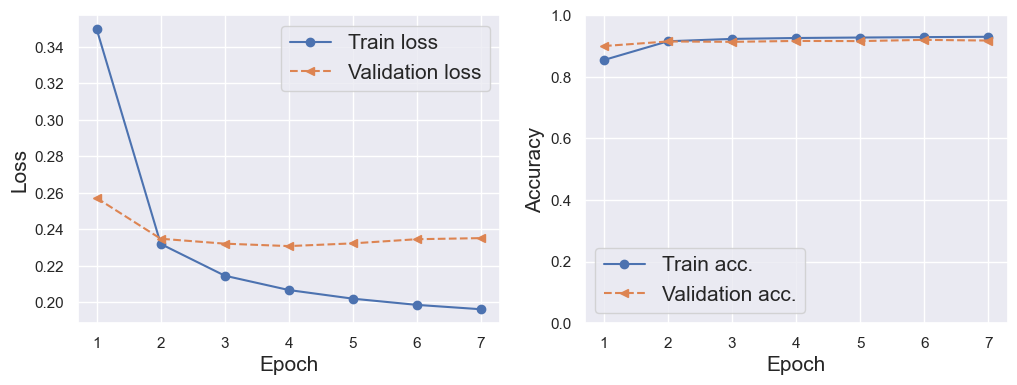

In [83]:
#5k vocab size, 25 output embedding, no hidden layer 
history_2_1 = train_embedding(vocab_size = 4843, 
                          embedding_output_dim = 25,
                          X_train_reduced = X_train_reduced2,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_2_1)

Epoch 1/10
3482/3482 [==============================] - 16s 4ms/step - loss: 0.3227 - accuracy: 0.8692 - val_loss: 0.2453 - val_accuracy: 0.9051
Epoch 2/10
3482/3482 [==============================] - 14s 4ms/step - loss: 0.2236 - accuracy: 0.9196 - val_loss: 0.2320 - val_accuracy: 0.9180
Epoch 3/10
3482/3482 [==============================] - 14s 4ms/step - loss: 0.2100 - accuracy: 0.9254 - val_loss: 0.2323 - val_accuracy: 0.9136
Epoch 4/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.2035 - accuracy: 0.9271 - val_loss: 0.2326 - val_accuracy: 0.9158
Epoch 5/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1996 - accuracy: 0.9287 - val_loss: 0.2343 - val_accuracy: 0.9155


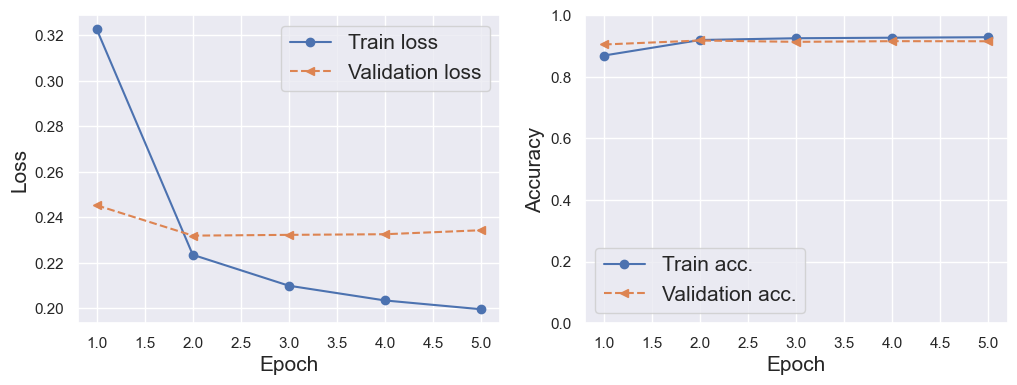

In [84]:
#5k vocab size, 50 output embedding, no hidden layer 
history_2_2 = train_embedding(vocab_size = 4843, 
                          embedding_output_dim = 50,
                          X_train_reduced = X_train_reduced2,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_2_2)

Epoch 1/10
3482/3482 [==============================] - 23s 6ms/step - loss: 0.3002 - accuracy: 0.8809 - val_loss: 0.2391 - val_accuracy: 0.9071
Epoch 2/10
3482/3482 [==============================] - 21s 6ms/step - loss: 0.2179 - accuracy: 0.9217 - val_loss: 0.2316 - val_accuracy: 0.9194
Epoch 3/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.2069 - accuracy: 0.9264 - val_loss: 0.2342 - val_accuracy: 0.9129
Epoch 4/10
3482/3482 [==============================] - 21s 6ms/step - loss: 0.2015 - accuracy: 0.9277 - val_loss: 0.2357 - val_accuracy: 0.9138
Epoch 5/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1984 - accuracy: 0.9290 - val_loss: 0.2368 - val_accuracy: 0.9161


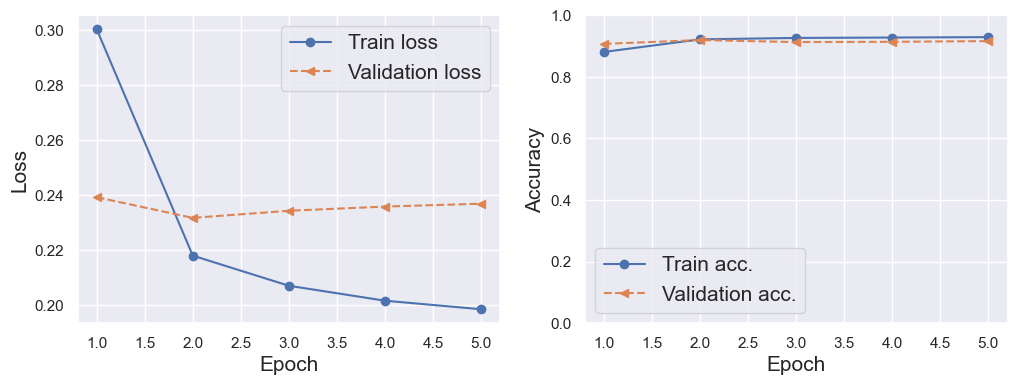

In [85]:
#5k vocab size, 100 output embedding, no hidden layer 
history_2_3 = train_embedding(vocab_size = 4843, 
                          embedding_output_dim = 100,
                          X_train_reduced = X_train_reduced2,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_2_3)

### Vocab size = 5k, 1 Hidden Layer

Epoch 1/10
3482/3482 [==============================] - 14s 4ms/step - loss: 0.2929 - accuracy: 0.8870 - val_loss: 0.2121 - val_accuracy: 0.9192
Epoch 2/10
3482/3482 [==============================] - 12s 3ms/step - loss: 0.2108 - accuracy: 0.9255 - val_loss: 0.2083 - val_accuracy: 0.9214
Epoch 3/10
3482/3482 [==============================] - 12s 4ms/step - loss: 0.1999 - accuracy: 0.9299 - val_loss: 0.2142 - val_accuracy: 0.9185
Epoch 4/10
3482/3482 [==============================] - 12s 3ms/step - loss: 0.1930 - accuracy: 0.9311 - val_loss: 0.2136 - val_accuracy: 0.9199
Epoch 5/10
3482/3482 [==============================] - 13s 4ms/step - loss: 0.1876 - accuracy: 0.9322 - val_loss: 0.2152 - val_accuracy: 0.9196


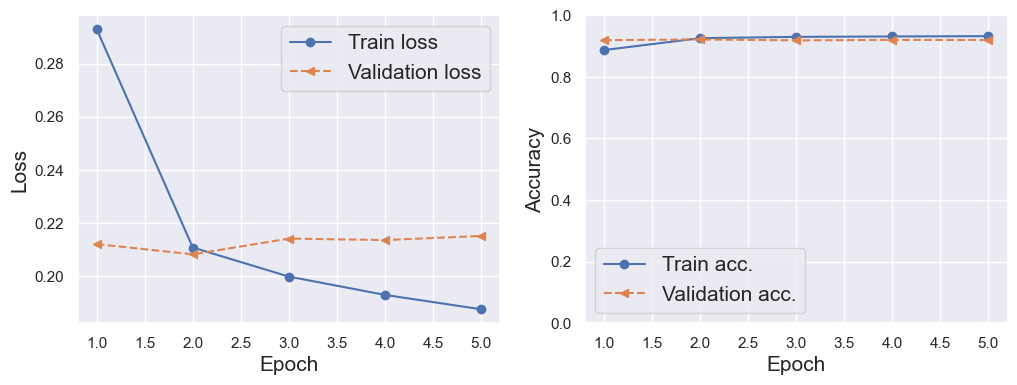

In [86]:
#5k vocab size, 25 output embedding, 1 hidden layer 
history_2_4 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 25,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_4)

Epoch 1/10
3482/3482 [==============================] - 16s 4ms/step - loss: 0.2616 - accuracy: 0.8987 - val_loss: 0.2080 - val_accuracy: 0.9197
Epoch 2/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.2005 - accuracy: 0.9270 - val_loss: 0.2060 - val_accuracy: 0.9222
Epoch 3/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1888 - accuracy: 0.9302 - val_loss: 0.2191 - val_accuracy: 0.9170
Epoch 4/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1803 - accuracy: 0.9326 - val_loss: 0.2132 - val_accuracy: 0.9214
Epoch 5/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1731 - accuracy: 0.9347 - val_loss: 0.2199 - val_accuracy: 0.9214


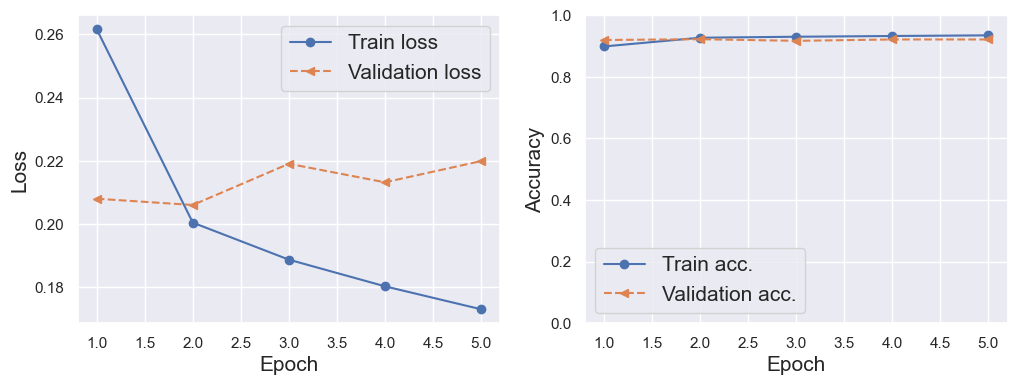

In [87]:
#5k vocab size, 50 output embedding, 1 hidden layer 
history_2_5 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_5)

Epoch 1/10
3482/3482 [==============================] - 16s 4ms/step - loss: 0.2733 - accuracy: 0.8967 - val_loss: 0.2084 - val_accuracy: 0.9220
Epoch 2/10
3482/3482 [==============================] - 16s 4ms/step - loss: 0.2088 - accuracy: 0.9255 - val_loss: 0.2083 - val_accuracy: 0.9225
Epoch 3/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1965 - accuracy: 0.9291 - val_loss: 0.2201 - val_accuracy: 0.9172
Epoch 4/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1891 - accuracy: 0.9303 - val_loss: 0.2188 - val_accuracy: 0.9201
Epoch 5/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.1838 - accuracy: 0.9310 - val_loss: 0.2236 - val_accuracy: 0.9205


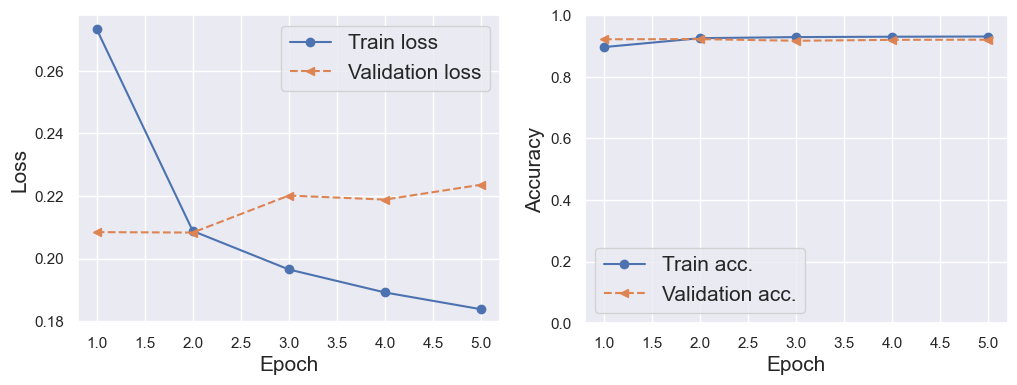

In [88]:
#5k vocab size, 50 output embedding, 1 hidden layer 
history_2_5_2 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_5_2)

Epoch 1/10
3482/3482 [==============================] - 23s 6ms/step - loss: 0.2427 - accuracy: 0.9059 - val_loss: 0.2056 - val_accuracy: 0.9209
Epoch 2/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1930 - accuracy: 0.9275 - val_loss: 0.2055 - val_accuracy: 0.9223
Epoch 3/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1799 - accuracy: 0.9314 - val_loss: 0.2275 - val_accuracy: 0.9136
Epoch 4/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1713 - accuracy: 0.9348 - val_loss: 0.2136 - val_accuracy: 0.9228
Epoch 5/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1637 - accuracy: 0.9376 - val_loss: 0.2207 - val_accuracy: 0.9219


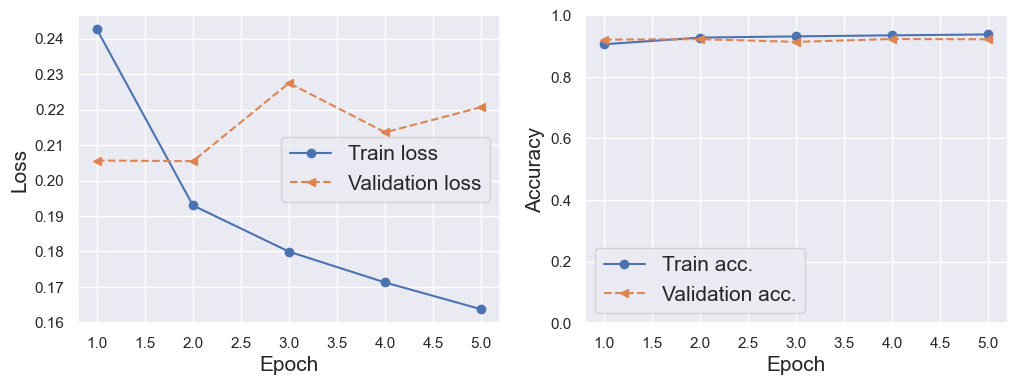

In [89]:
#5k vocab size, 100 output embedding, 1 hidden layer 
history_2_6 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [100],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_6)

Epoch 1/10
3482/3482 [==============================] - 24s 6ms/step - loss: 0.2528 - accuracy: 0.9025 - val_loss: 0.2073 - val_accuracy: 0.9208
Epoch 2/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1982 - accuracy: 0.9274 - val_loss: 0.2068 - val_accuracy: 0.9218
Epoch 3/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1870 - accuracy: 0.9300 - val_loss: 0.2245 - val_accuracy: 0.9136
Epoch 4/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1786 - accuracy: 0.9329 - val_loss: 0.2148 - val_accuracy: 0.9224
Epoch 5/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1693 - accuracy: 0.9358 - val_loss: 0.2202 - val_accuracy: 0.9220


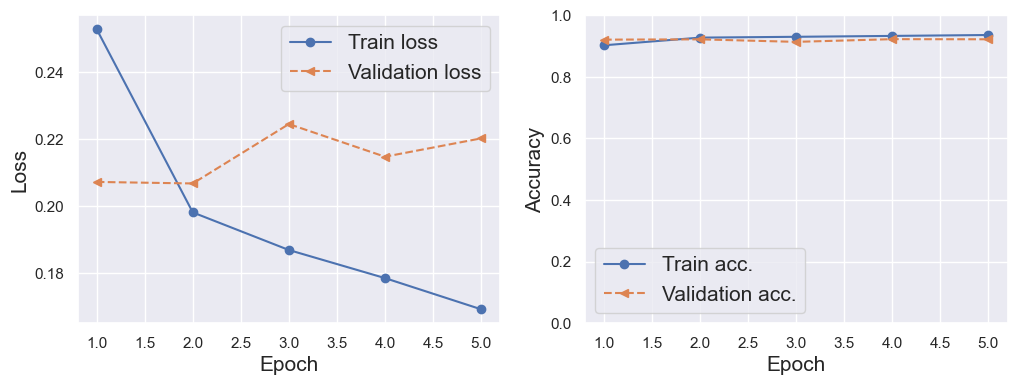

In [90]:
#5k vocab size, 100 output embedding, 1 hidden layer 
history_2_6_2 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_6_2)

Epoch 1/10
3482/3482 [==============================] - 23s 6ms/step - loss: 0.2694 - accuracy: 0.8982 - val_loss: 0.2069 - val_accuracy: 0.9224
Epoch 2/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.2062 - accuracy: 0.9257 - val_loss: 0.2085 - val_accuracy: 0.9213
Epoch 3/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1957 - accuracy: 0.9292 - val_loss: 0.2235 - val_accuracy: 0.9148
Epoch 4/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1876 - accuracy: 0.9314 - val_loss: 0.2162 - val_accuracy: 0.9209


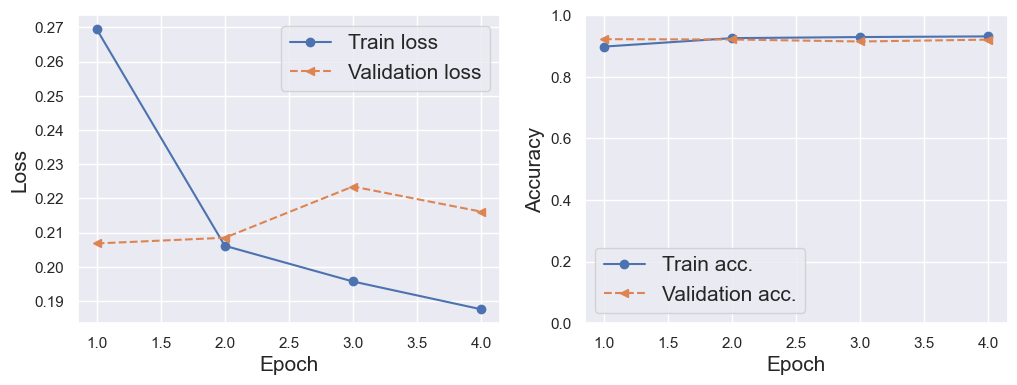

In [91]:
#5k vocab size, 100 output embedding, 1 hidden layer 
history_2_6_3 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_6_3)

### Vocab size = 5k, 2 Hidden Layers

Epoch 1/10
3482/3482 [==============================] - 14s 4ms/step - loss: 0.2937 - accuracy: 0.8919 - val_loss: 0.2094 - val_accuracy: 0.9215
Epoch 2/10
3482/3482 [==============================] - 13s 4ms/step - loss: 0.2272 - accuracy: 0.9231 - val_loss: 0.2078 - val_accuracy: 0.9220
Epoch 3/10
3482/3482 [==============================] - 13s 4ms/step - loss: 0.2156 - accuracy: 0.9253 - val_loss: 0.2146 - val_accuracy: 0.9193
Epoch 4/10
3482/3482 [==============================] - 13s 4ms/step - loss: 0.2091 - accuracy: 0.9277 - val_loss: 0.2175 - val_accuracy: 0.9210
Epoch 5/10
3482/3482 [==============================] - 12s 4ms/step - loss: 0.2028 - accuracy: 0.9296 - val_loss: 0.2201 - val_accuracy: 0.9219


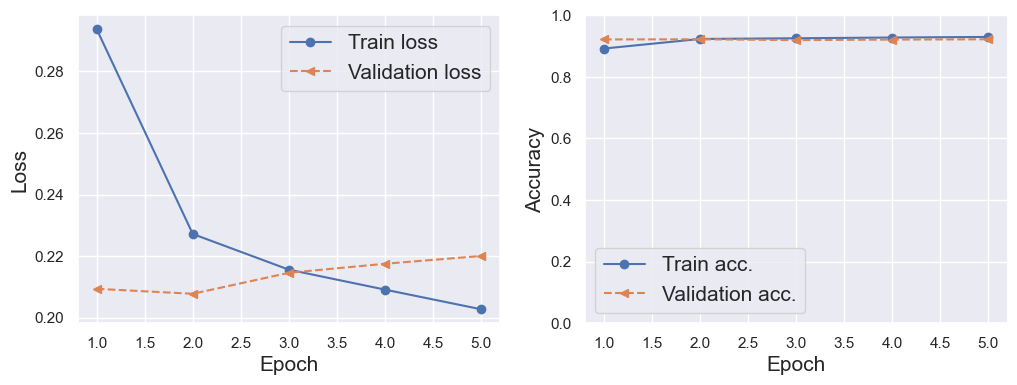

In [92]:
#5k vocab size, 25 output embedding, 2 hidden layer 
history_2_7 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 25,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_7)

Epoch 1/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2613 - accuracy: 0.9019 - val_loss: 0.2058 - val_accuracy: 0.9214
Epoch 2/10
3482/3482 [==============================] - 16s 5ms/step - loss: 0.2069 - accuracy: 0.9254 - val_loss: 0.2079 - val_accuracy: 0.9222
Epoch 3/10
3482/3482 [==============================] - 16s 5ms/step - loss: 0.1937 - accuracy: 0.9296 - val_loss: 0.2203 - val_accuracy: 0.9163
Epoch 4/10
3482/3482 [==============================] - 16s 4ms/step - loss: 0.1856 - accuracy: 0.9320 - val_loss: 0.2172 - val_accuracy: 0.9204


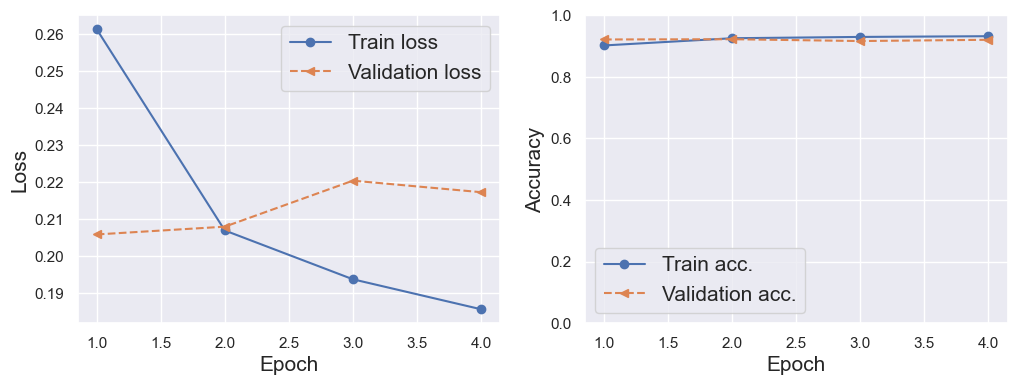

In [93]:
#5k vocab size, 50 output embedding, 2 hidden layer 
history_2_8 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [50, 32],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_8)

Epoch 1/10
3482/3482 [==============================] - 17s 4ms/step - loss: 0.2900 - accuracy: 0.8942 - val_loss: 0.2103 - val_accuracy: 0.9201
Epoch 2/10
3482/3482 [==============================] - 16s 5ms/step - loss: 0.2248 - accuracy: 0.9232 - val_loss: 0.2173 - val_accuracy: 0.9169
Epoch 3/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.2149 - accuracy: 0.9258 - val_loss: 0.2187 - val_accuracy: 0.9172
Epoch 4/10
3482/3482 [==============================] - 16s 5ms/step - loss: 0.2081 - accuracy: 0.9270 - val_loss: 0.2187 - val_accuracy: 0.9206


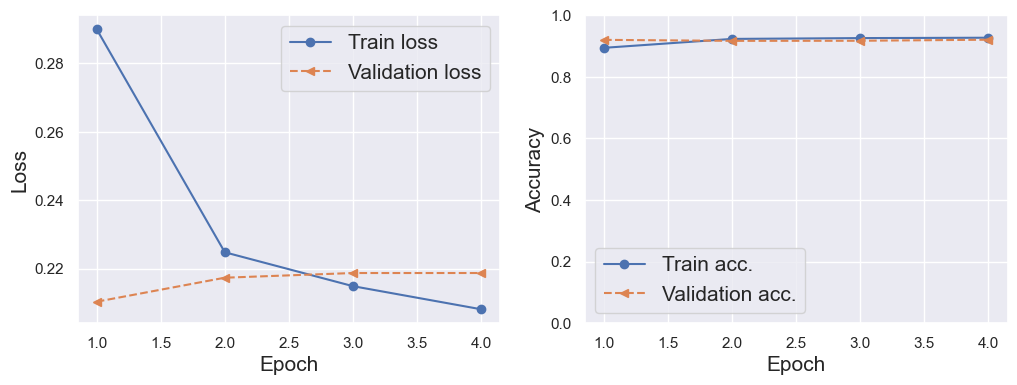

In [94]:
#5k vocab size, 50 output embedding, 2 hidden layer 
history_2_8_2 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_8_2)

Epoch 1/10
3482/3482 [==============================] - 24s 7ms/step - loss: 0.2466 - accuracy: 0.9072 - val_loss: 0.2165 - val_accuracy: 0.9188
Epoch 2/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.1990 - accuracy: 0.9266 - val_loss: 0.2067 - val_accuracy: 0.9220
Epoch 3/10
3482/3482 [==============================] - 23s 6ms/step - loss: 0.1841 - accuracy: 0.9315 - val_loss: 0.2352 - val_accuracy: 0.9087
Epoch 4/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.1744 - accuracy: 0.9354 - val_loss: 0.2143 - val_accuracy: 0.9228
Epoch 5/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.1649 - accuracy: 0.9391 - val_loss: 0.2201 - val_accuracy: 0.9225


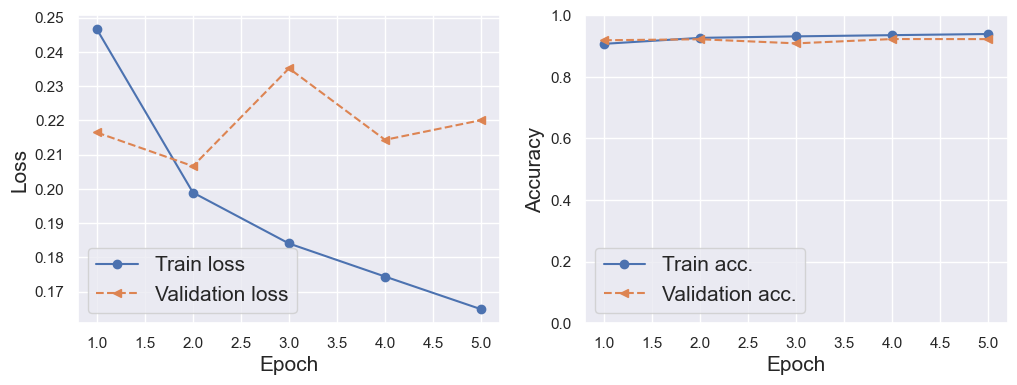

In [95]:
#5k vocab size, 100 output embedding, 2 hidden layer 
history_2_9 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [100, 50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_9)

Epoch 1/10
3482/3482 [==============================] - 24s 6ms/step - loss: 0.2595 - accuracy: 0.9023 - val_loss: 0.2072 - val_accuracy: 0.9221
Epoch 2/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.2070 - accuracy: 0.9257 - val_loss: 0.2090 - val_accuracy: 0.9230
Epoch 3/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1929 - accuracy: 0.9293 - val_loss: 0.2204 - val_accuracy: 0.9173
Epoch 4/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.1840 - accuracy: 0.9333 - val_loss: 0.2167 - val_accuracy: 0.9218


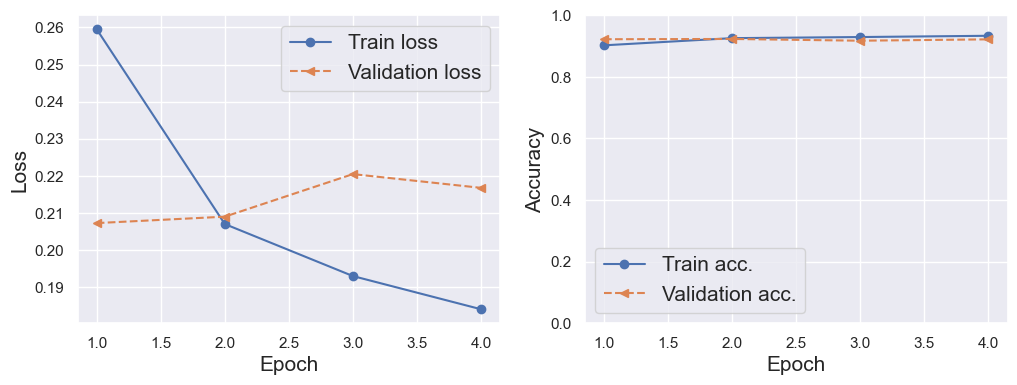

In [96]:
#5k vocab size, 100 output embedding, 2 hidden layer 
history_2_9_2 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [50, 32],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_9_2)

Epoch 1/10
3482/3482 [==============================] - 24s 6ms/step - loss: 0.2857 - accuracy: 0.8950 - val_loss: 0.2078 - val_accuracy: 0.9202
Epoch 2/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.2234 - accuracy: 0.9243 - val_loss: 0.2144 - val_accuracy: 0.9211
Epoch 3/10
3482/3482 [==============================] - 30s 9ms/step - loss: 0.2110 - accuracy: 0.9273 - val_loss: 0.2177 - val_accuracy: 0.9205
Epoch 4/10
3482/3482 [==============================] - 37s 10ms/step - loss: 0.2035 - accuracy: 0.9288 - val_loss: 0.2226 - val_accuracy: 0.9209


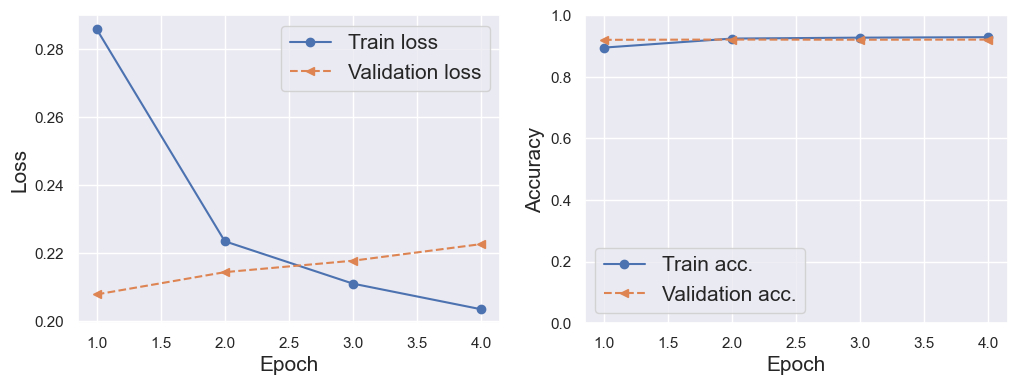

In [97]:
#5k vocab size, 100 output embedding, 2 hidden layer 
history_2_9_3 = train_embedding(vocab_size = 4843, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced2,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_2_9_3)

### Vocab size = 2.5k, No Hidden Layers 

Epoch 1/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.3546 - accuracy: 0.8526 - val_loss: 0.2629 - val_accuracy: 0.8980
Epoch 2/10
3482/3482 [==============================] - 19s 5ms/step - loss: 0.2396 - accuracy: 0.9123 - val_loss: 0.2415 - val_accuracy: 0.9122
Epoch 3/10
3482/3482 [==============================] - 20s 6ms/step - loss: 0.2248 - accuracy: 0.9192 - val_loss: 0.2392 - val_accuracy: 0.9097
Epoch 4/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2190 - accuracy: 0.9211 - val_loss: 0.2373 - val_accuracy: 0.9140
Epoch 5/10
3482/3482 [==============================] - 12s 4ms/step - loss: 0.2159 - accuracy: 0.9219 - val_loss: 0.2383 - val_accuracy: 0.9127
Epoch 6/10
3482/3482 [==============================] - 12s 3ms/step - loss: 0.2140 - accuracy: 0.9225 - val_loss: 0.2400 - val_accuracy: 0.9171
Epoch 7/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.2127 - accuracy: 0.9232 - val_loss: 0.2397 - val_ac

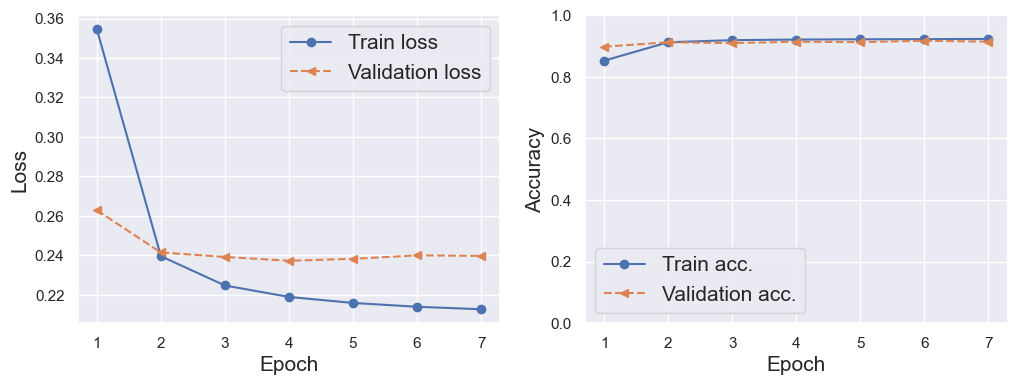

In [98]:
#10k vocab size, 25 output embedding, no hidden layer 
history_3_1 = train_embedding(vocab_size = 2473, 
                          embedding_output_dim = 25,
                          X_train_reduced = X_train_reduced3,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_3_1)

Epoch 1/10
3482/3482 [==============================] - 20s 5ms/step - loss: 0.3253 - accuracy: 0.8679 - val_loss: 0.2503 - val_accuracy: 0.9026
Epoch 2/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.2313 - accuracy: 0.9160 - val_loss: 0.2386 - val_accuracy: 0.9149
Epoch 3/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.2209 - accuracy: 0.9209 - val_loss: 0.2396 - val_accuracy: 0.9094
Epoch 4/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.2168 - accuracy: 0.9216 - val_loss: 0.2385 - val_accuracy: 0.9122
Epoch 5/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.2148 - accuracy: 0.9220 - val_loss: 0.2395 - val_accuracy: 0.9126
Epoch 6/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2134 - accuracy: 0.9225 - val_loss: 0.2422 - val_accuracy: 0.9167
Epoch 7/10
3482/3482 [==============================] - 16s 5ms/step - loss: 0.2126 - accuracy: 0.9229 - val_loss: 0.2414 - val_ac

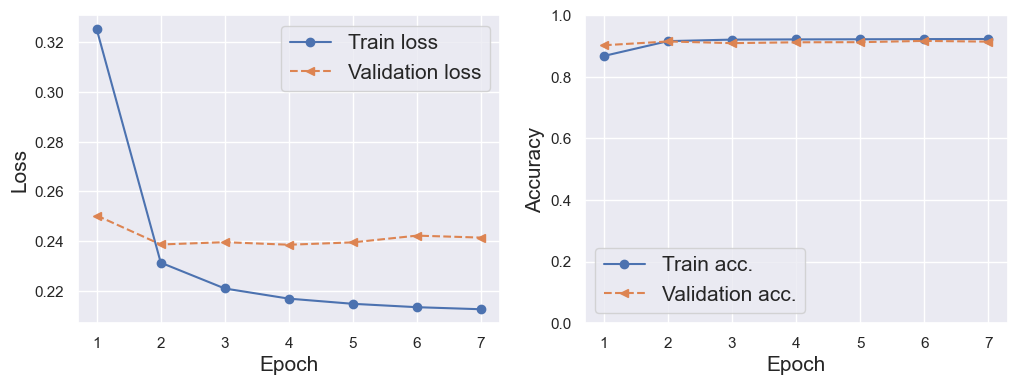

In [99]:
#10k vocab size, 50 output embedding, no hidden layer 
history_3_2 = train_embedding(vocab_size = 2473, 
                          embedding_output_dim = 50,
                          X_train_reduced = X_train_reduced3,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_3_2)

Epoch 1/10
3482/3482 [==============================] - 23s 6ms/step - loss: 0.3033 - accuracy: 0.8794 - val_loss: 0.2451 - val_accuracy: 0.9046
Epoch 2/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2270 - accuracy: 0.9178 - val_loss: 0.2387 - val_accuracy: 0.9164
Epoch 3/10
3482/3482 [==============================] - 27s 8ms/step - loss: 0.2194 - accuracy: 0.9210 - val_loss: 0.2414 - val_accuracy: 0.9084
Epoch 4/10
3482/3482 [==============================] - 28s 8ms/step - loss: 0.2163 - accuracy: 0.9214 - val_loss: 0.2407 - val_accuracy: 0.9097
Epoch 5/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.2149 - accuracy: 0.9219 - val_loss: 0.2406 - val_accuracy: 0.9126


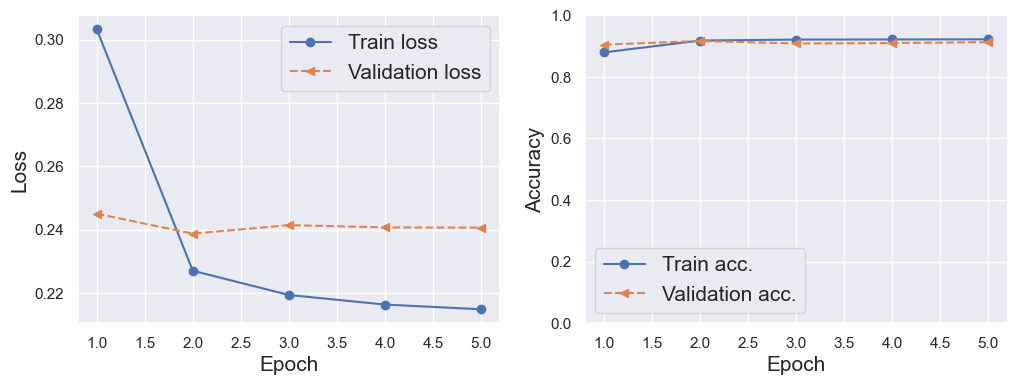

In [100]:
#10k vocab size, 50 output embedding, no hidden layer 
history_3_3 = train_embedding(vocab_size = 2473, 
                          embedding_output_dim = 100,
                          X_train_reduced = X_train_reduced3,
                          y_train = y_train,
                          epochs = 10)
plot_loss_accuracy(history_3_3)

### Vocab size = 2.5k, 1 Hidden Layer

Epoch 1/10
3482/3482 [==============================] - 15s 4ms/step - loss: 0.2996 - accuracy: 0.8851 - val_loss: 0.2188 - val_accuracy: 0.9164
Epoch 2/10
3482/3482 [==============================] - 13s 4ms/step - loss: 0.2223 - accuracy: 0.9212 - val_loss: 0.2171 - val_accuracy: 0.9167
Epoch 3/10
3482/3482 [==============================] - 19s 6ms/step - loss: 0.2128 - accuracy: 0.9232 - val_loss: 0.2221 - val_accuracy: 0.9144
Epoch 4/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.2075 - accuracy: 0.9246 - val_loss: 0.2216 - val_accuracy: 0.9150
Epoch 5/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2041 - accuracy: 0.9251 - val_loss: 0.2217 - val_accuracy: 0.9180


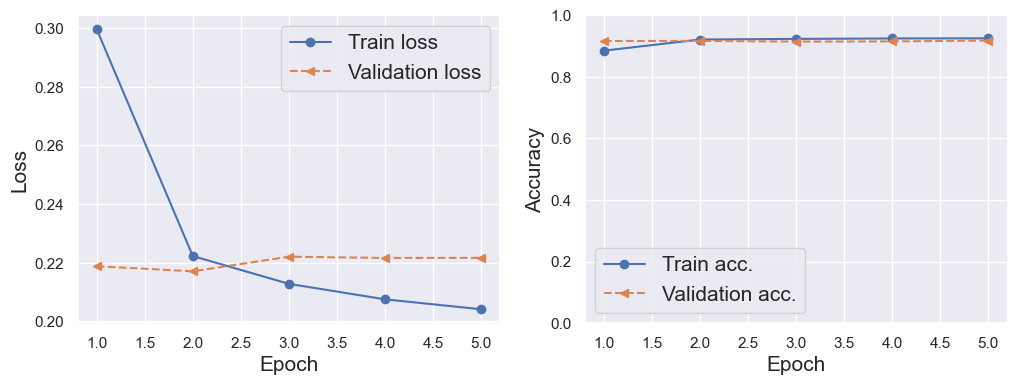

In [101]:
#2.5k vocab size, 25 output embedding, 1 hidden layer 
history_3_4 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 25,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_4)

Epoch 1/10
3482/3482 [==============================] - 21s 6ms/step - loss: 0.2664 - accuracy: 0.8968 - val_loss: 0.2156 - val_accuracy: 0.9173
Epoch 2/10
3482/3482 [==============================] - 19s 6ms/step - loss: 0.2100 - accuracy: 0.9223 - val_loss: 0.2134 - val_accuracy: 0.9174
Epoch 3/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.2023 - accuracy: 0.9242 - val_loss: 0.2278 - val_accuracy: 0.9125
Epoch 4/10
3482/3482 [==============================] - 19s 5ms/step - loss: 0.1974 - accuracy: 0.9257 - val_loss: 0.2173 - val_accuracy: 0.9183
Epoch 5/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.1931 - accuracy: 0.9258 - val_loss: 0.2206 - val_accuracy: 0.9180


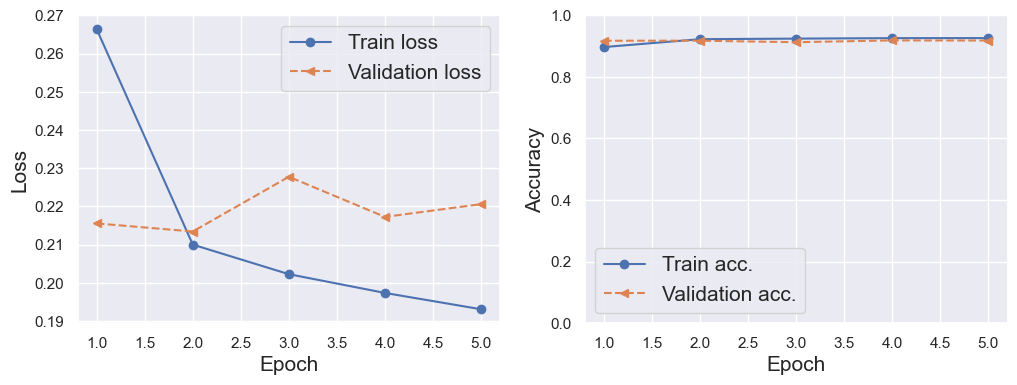

In [102]:
#2.5k vocab size, 50 output embedding, 1 hidden layer 
history_3_5 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_5)

Epoch 1/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.2878 - accuracy: 0.8911 - val_loss: 0.2149 - val_accuracy: 0.9175
Epoch 2/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.2216 - accuracy: 0.9216 - val_loss: 0.2163 - val_accuracy: 0.9172
Epoch 3/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.2145 - accuracy: 0.9241 - val_loss: 0.2228 - val_accuracy: 0.9133
Epoch 4/10
3482/3482 [==============================] - 22s 6ms/step - loss: 0.2084 - accuracy: 0.9244 - val_loss: 0.2204 - val_accuracy: 0.9161


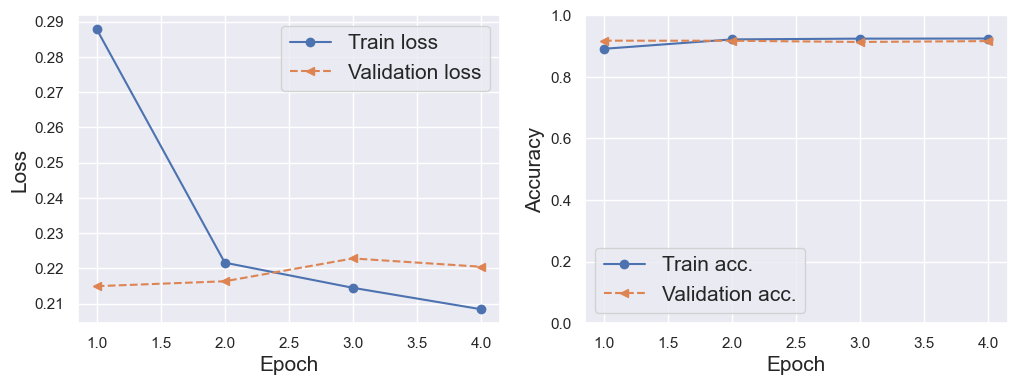

In [103]:
#2.5k vocab size, 50 output embedding, 1 hidden layer 
history_3_5_2 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_5_2)

Epoch 1/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2496 - accuracy: 0.9028 - val_loss: 0.2140 - val_accuracy: 0.9173
Epoch 2/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2029 - accuracy: 0.9232 - val_loss: 0.2115 - val_accuracy: 0.9194
Epoch 3/10
3482/3482 [==============================] - 26s 8ms/step - loss: 0.1937 - accuracy: 0.9268 - val_loss: 0.2284 - val_accuracy: 0.9120
Epoch 4/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.1871 - accuracy: 0.9293 - val_loss: 0.2172 - val_accuracy: 0.9194
Epoch 5/10
3482/3482 [==============================] - 24s 7ms/step - loss: 0.1820 - accuracy: 0.9310 - val_loss: 0.2183 - val_accuracy: 0.9196


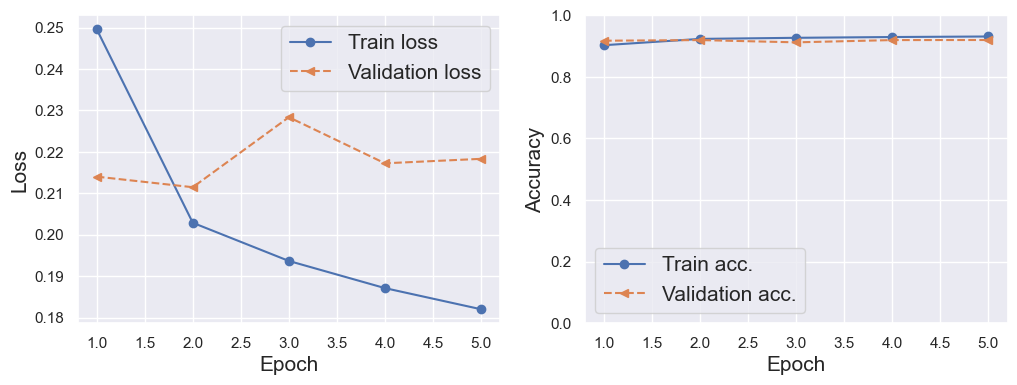

In [104]:
#2.5k vocab size, 100 output embedding, 1 hidden layer 
history_3_6 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [100],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_6)

Epoch 1/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.2574 - accuracy: 0.9012 - val_loss: 0.2147 - val_accuracy: 0.9175
Epoch 2/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2097 - accuracy: 0.9217 - val_loss: 0.2144 - val_accuracy: 0.9173
Epoch 3/10
3482/3482 [==============================] - 27s 8ms/step - loss: 0.2000 - accuracy: 0.9249 - val_loss: 0.2270 - val_accuracy: 0.9132
Epoch 4/10
3482/3482 [==============================] - 24s 7ms/step - loss: 0.1952 - accuracy: 0.9261 - val_loss: 0.2184 - val_accuracy: 0.9187
Epoch 5/10
3482/3482 [==============================] - 34s 10ms/step - loss: 0.1895 - accuracy: 0.9283 - val_loss: 0.2196 - val_accuracy: 0.9194


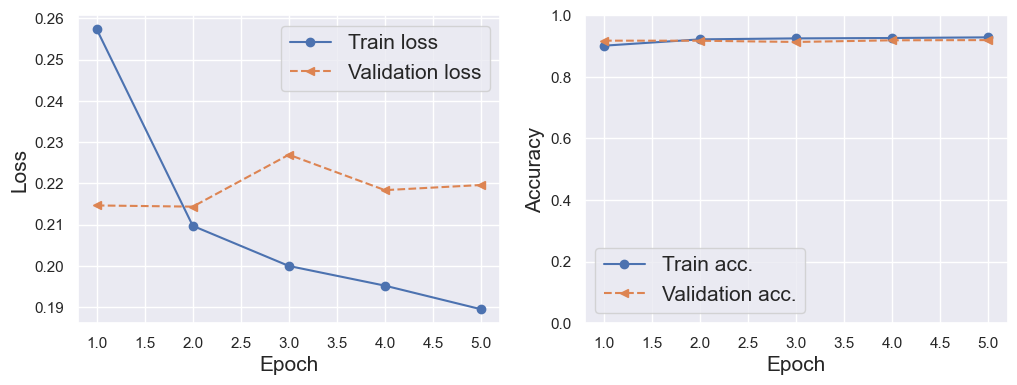

In [105]:
#2.5k vocab size, 100 output embedding, 1 hidden layer 
history_3_6_2 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_6_2)

Epoch 1/10
3482/3482 [==============================] - 33s 9ms/step - loss: 0.2753 - accuracy: 0.8959 - val_loss: 0.2139 - val_accuracy: 0.9186
Epoch 2/10
3482/3482 [==============================] - 27s 8ms/step - loss: 0.2195 - accuracy: 0.9212 - val_loss: 0.2182 - val_accuracy: 0.9184
Epoch 3/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.2120 - accuracy: 0.9231 - val_loss: 0.2276 - val_accuracy: 0.9129
Epoch 4/10
3482/3482 [==============================] - 27s 8ms/step - loss: 0.2065 - accuracy: 0.9249 - val_loss: 0.2178 - val_accuracy: 0.9184


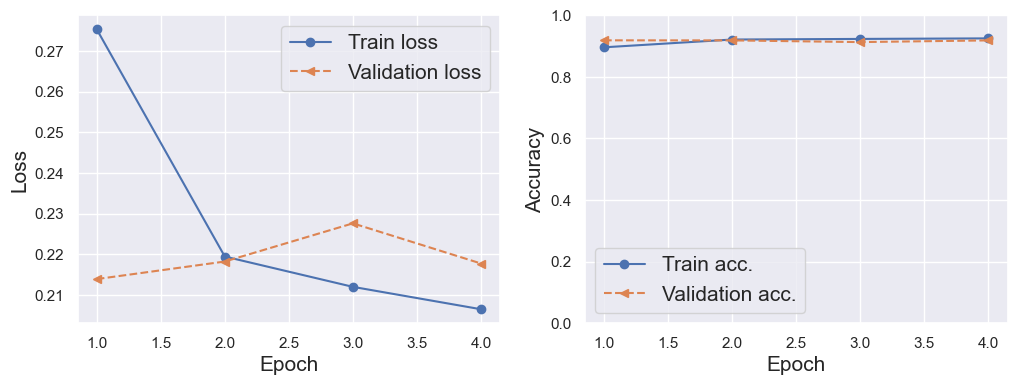

In [106]:
#2.5k vocab size, 100 output embedding, 1 hidden layer 
history_3_6_3 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_6_3)

### Vocab size = 2.5, 2 Hidden Layers

Epoch 1/10
3482/3482 [==============================] - 18s 5ms/step - loss: 0.3023 - accuracy: 0.8907 - val_loss: 0.2170 - val_accuracy: 0.9184
Epoch 2/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2404 - accuracy: 0.9173 - val_loss: 0.2256 - val_accuracy: 0.9152
Epoch 3/10
3482/3482 [==============================] - 16s 5ms/step - loss: 0.2309 - accuracy: 0.9194 - val_loss: 0.2297 - val_accuracy: 0.9071
Epoch 4/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2245 - accuracy: 0.9212 - val_loss: 0.2189 - val_accuracy: 0.9176


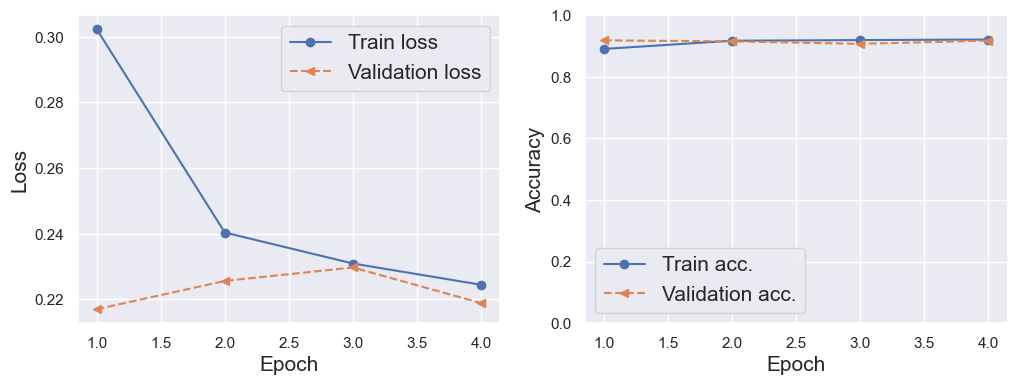

In [107]:
#2.5k vocab size, 25 output embedding, 2 hidden layer 
history_3_7 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 25,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_7)

Epoch 1/10
3482/3482 [==============================] - 20s 5ms/step - loss: 0.2684 - accuracy: 0.9004 - val_loss: 0.2213 - val_accuracy: 0.9182
Epoch 2/10
3482/3482 [==============================] - 19s 6ms/step - loss: 0.2201 - accuracy: 0.9210 - val_loss: 0.2162 - val_accuracy: 0.9187
Epoch 3/10
3482/3482 [==============================] - 20s 6ms/step - loss: 0.2110 - accuracy: 0.9234 - val_loss: 0.2353 - val_accuracy: 0.9080
Epoch 4/10
3482/3482 [==============================] - 20s 6ms/step - loss: 0.2042 - accuracy: 0.9266 - val_loss: 0.2171 - val_accuracy: 0.9200
Epoch 5/10
3482/3482 [==============================] - 19s 6ms/step - loss: 0.1978 - accuracy: 0.9286 - val_loss: 0.2201 - val_accuracy: 0.9215


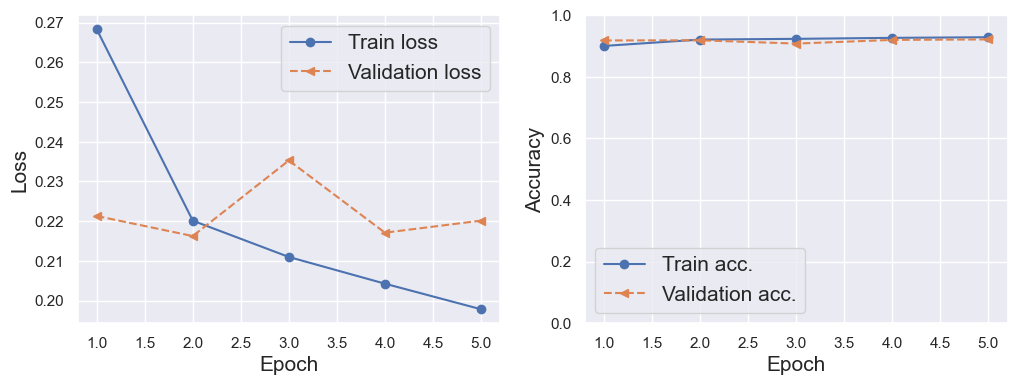

In [108]:
#2.5k vocab size, 50 output embedding, 2 hidden layer 
history_3_8 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [50, 25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_8)

Epoch 1/10
3482/3482 [==============================] - 19s 5ms/step - loss: 0.2956 - accuracy: 0.8888 - val_loss: 0.2152 - val_accuracy: 0.9194
Epoch 2/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2352 - accuracy: 0.9197 - val_loss: 0.2199 - val_accuracy: 0.9164
Epoch 3/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2242 - accuracy: 0.9229 - val_loss: 0.2295 - val_accuracy: 0.9094
Epoch 4/10
3482/3482 [==============================] - 17s 5ms/step - loss: 0.2208 - accuracy: 0.9236 - val_loss: 0.2219 - val_accuracy: 0.9165


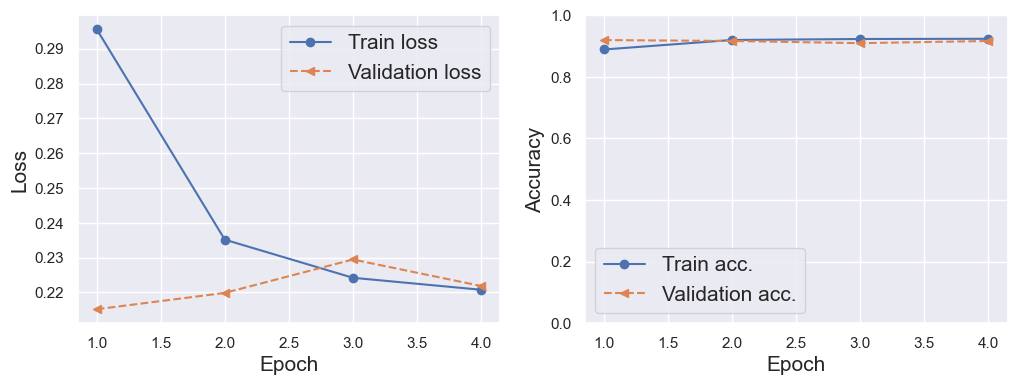

In [109]:
#2.5k vocab size, 50 output embedding, 2 hidden layer 
history_3_8_2 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 50,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_8_2)

Epoch 1/10
3482/3482 [==============================] - 24s 6ms/step - loss: 0.2532 - accuracy: 0.9044 - val_loss: 0.2218 - val_accuracy: 0.9164
Epoch 2/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.2088 - accuracy: 0.9224 - val_loss: 0.2125 - val_accuracy: 0.9196
Epoch 3/10
3482/3482 [==============================] - 24s 7ms/step - loss: 0.1973 - accuracy: 0.9274 - val_loss: 0.2315 - val_accuracy: 0.9097
Epoch 4/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.1907 - accuracy: 0.9294 - val_loss: 0.2150 - val_accuracy: 0.9209
Epoch 5/10
3482/3482 [==============================] - 25s 7ms/step - loss: 0.1842 - accuracy: 0.9314 - val_loss: 0.2177 - val_accuracy: 0.9198


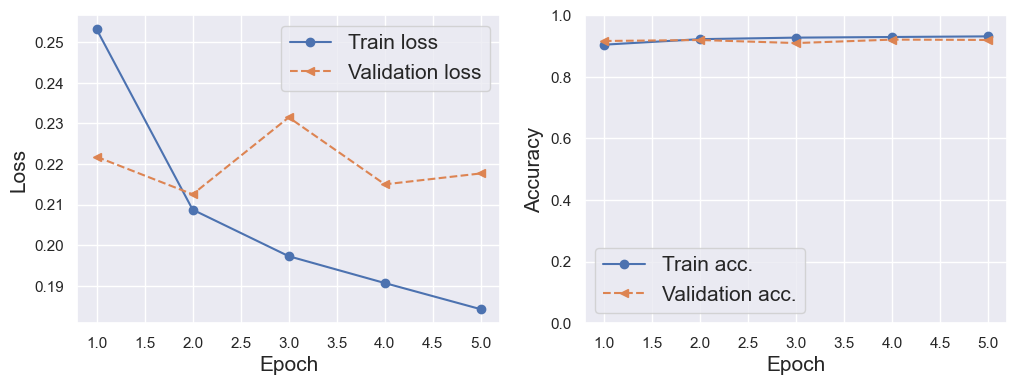

In [110]:
#2.5k vocab size, 100 output embedding, 2 hidden layer 
history_3_9 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [100, 50],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_9)

Epoch 1/10
3482/3482 [==============================] - 24s 6ms/step - loss: 0.2686 - accuracy: 0.9001 - val_loss: 0.2213 - val_accuracy: 0.9177
Epoch 2/10
3482/3482 [==============================] - 28s 8ms/step - loss: 0.2210 - accuracy: 0.9206 - val_loss: 0.2200 - val_accuracy: 0.9173
Epoch 3/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.2108 - accuracy: 0.9238 - val_loss: 0.2301 - val_accuracy: 0.9117
Epoch 4/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.2050 - accuracy: 0.9261 - val_loss: 0.2222 - val_accuracy: 0.9178
Epoch 5/10
3482/3482 [==============================] - 24s 7ms/step - loss: 0.1966 - accuracy: 0.9282 - val_loss: 0.2249 - val_accuracy: 0.9202


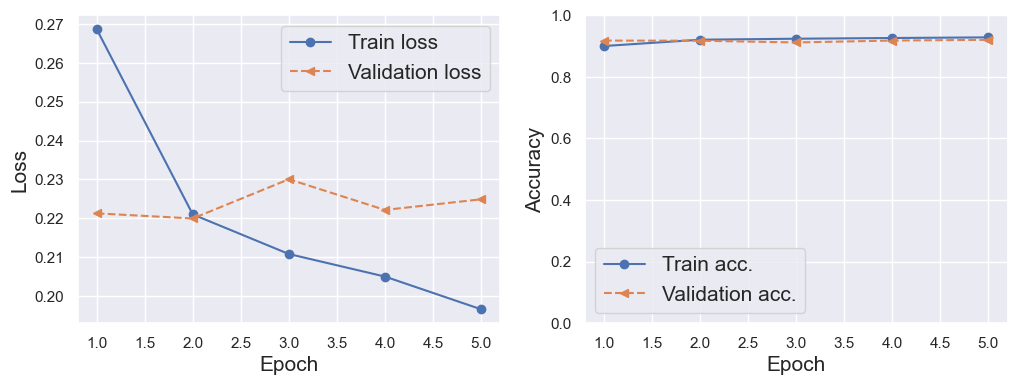

In [111]:
#2.5k vocab size, 100 output embedding, 2 hidden layer 
history_3_9_2 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [50, 25],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_9_2)

Epoch 1/10
3482/3482 [==============================] - 24s 7ms/step - loss: 0.2927 - accuracy: 0.8946 - val_loss: 0.2148 - val_accuracy: 0.9183
Epoch 2/10
3482/3482 [==============================] - 26s 7ms/step - loss: 0.2362 - accuracy: 0.9182 - val_loss: 0.2235 - val_accuracy: 0.9162
Epoch 3/10
3482/3482 [==============================] - 23s 7ms/step - loss: 0.2249 - accuracy: 0.9211 - val_loss: 0.2220 - val_accuracy: 0.9146
Epoch 4/10
3482/3482 [==============================] - 28s 8ms/step - loss: 0.2209 - accuracy: 0.9218 - val_loss: 0.2235 - val_accuracy: 0.9180


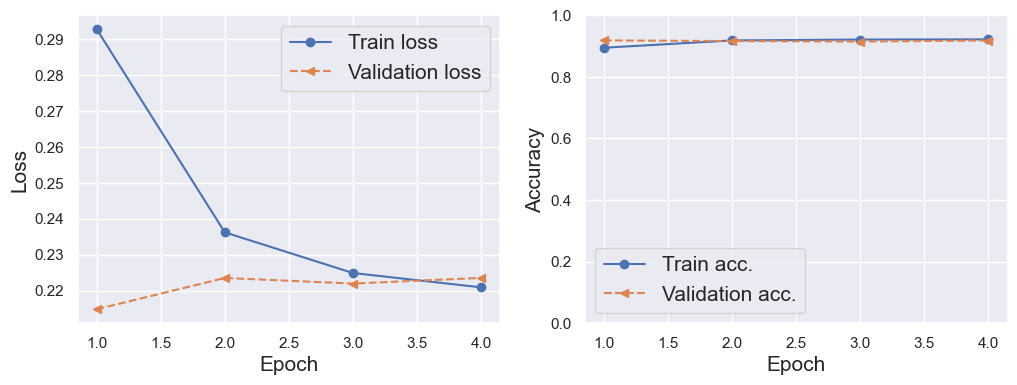

In [112]:
#2.5k vocab size, 100 output embedding, 2 hidden layer 
history_3_9_3 = train_embedding(vocab_size = 2473, 
                              embedding_output_dim = 100,
                              X_train_reduced = X_train_reduced3,
                              y_train = y_train,
                              hidden_layers = [25, 16],
                              epochs = 10,
                              random_state = 5234)
plot_loss_accuracy(history_3_9_3)

### Final Embeddings Model

Use model with highest validation accuracy 

In [15]:
#5k vocab size, 100 output embedding, 2 hidden layer 
vocab_size = 4843
embedding_output_dim = 100
X_train_reduced = X_train_reduced2
y_train = y_train
hidden_layers = [100, 50]
epochs = 10
random_state = 5234


In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(random_state)
#Add early stopping to prevent extreme overfitting 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = vocab_size + 2, #Add 2 for padding and unknown tokens
                                   output_dim = embedding_output_dim))
model.add(tf.keras.layers.GlobalAveragePooling1D())

for nodes in hidden_layers:
    model.add(tf.keras.layers.Dense(nodes, activation = "relu"))
    model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(units = 1, activation = "sigmoid"))

model.compile(loss = "binary_crossentropy",
         optimizer = "adam", 
         metrics = ["accuracy"])
tf.random.set_seed(random_state)
np.random.seed(random_state)
history = model.fit(
    x = X_train_reduced,
    y = y_train,
    validation_split=0.2, 
    epochs=epochs, 
    callbacks=[callback])

Epoch 1/10
3482/3482 [==============================] - 32s 9ms/step - loss: 0.2458 - accuracy: 0.9073 - val_loss: 0.2153 - val_accuracy: 0.9192
Epoch 2/10
3482/3482 [==============================] - 34s 10ms/step - loss: 0.1980 - accuracy: 0.9271 - val_loss: 0.2085 - val_accuracy: 0.9222
Epoch 3/10
3482/3482 [==============================] - 32s 9ms/step - loss: 0.1834 - accuracy: 0.9321 - val_loss: 0.2331 - val_accuracy: 0.9100
Epoch 4/10
3482/3482 [==============================] - 33s 9ms/step - loss: 0.1725 - accuracy: 0.9358 - val_loss: 0.2126 - val_accuracy: 0.9241
Epoch 5/10
3482/3482 [==============================] - 33s 9ms/step - loss: 0.1640 - accuracy: 0.9394 - val_loss: 0.2240 - val_accuracy: 0.9221


### Translate Text to Embeddings

In [27]:
#Translate each word to their respective word embedding 
X_train_embedded = []
embeddings_lookup = model.layers[0].get_weights()[0]
#For each sentence 
for i in range(X_train_reduced2.shape[0]):
    #Lookup the coded word in the embeddings matrix and concatenate each word into a list
    embedding_row = list(pd.Series(X_train_reduced2[i]).apply(lambda x: list(embeddings_lookup[x])).values)
    X_train_embedded.append(embedding_row)
X_train_embedded = np.array(X_train_embedded)
    

In [292]:
X_val_embedded = []

for i in range(X_val_reduced2.shape[0]):
    embedding_row = list(pd.Series(X_val_reduced2[i]).apply(lambda x: list(embeddings_lookup[x])).values)
    X_val_embedded.append(embedding_row)
X_val_embedded = np.array(X_val_embedded)
    

In [293]:
X_test_embedded = []

for i in range(X_test_reduced2.shape[0]):
    embedding_row = list(pd.Series(X_test_reduced2[i]).apply(lambda x: list(embeddings_lookup[x])).values)
    X_test_embedded.append(embedding_row)
X_test_embedded = np.array(X_test_embedded)
    

In [295]:
print(X_train_embedded.shape)
print(X_val_embedded.shape)
print(X_test_embedded.shape)

(139243, 100, 100)
(46415, 100, 100)
(46415, 100, 100)


Each row has 100 padded words, each word has a size 100 embedded vector

In [180]:
# model.save("model_word_embedding.keras")
# with open('embeddings_trained.pkl', 'wb') as handle:
#     pickle.dump(embeddings_lookup, handle)
# with open('X_train_word_embedded.pkl', 'wb') as handle:
#     pickle.dump(X_train_embedded, handle)
# with open('X_val_word_embedded.pkl', 'wb') as handle:
#     pickle.dump(X_val_embedded, handle)
# with open('X_test_word_embedded.pkl', 'wb') as handle:
#     pickle.dump(X_test_embedded, handle)

# with open('X_train_reduced.pkl', 'wb') as handle:
#     pickle.dump(X_train_reduced2, handle)
# with open('X_val_reduced.pkl', 'wb') as handle:
#     pickle.dump(X_val_reduced2, handle)
# with open('X_test_reduced.pkl', 'wb') as handle:
#     pickle.dump(X_test_reduced2, handle)


## Visualize embeddings

Pulled from Cornelia's Week 9 notebook: https://github.com/MIDS-W207/coursework_2022/blob/main/Demos_CorneliaIlin/week09/Week9_Sequence_modelling_embeddings.ipynb

In [ ]:
# get trained embeddings
embeddings_trained = model.layers[0].get_weights()[0]

# remove embedings at index 0 and last index
# these correspond to the additional indices added for padding (0)
# and out of vocabulary words (vocab size + 1).
embeddings_trained = embeddings_trained[1:-1]

In [132]:
# create an instance of the PCA class
pca = PCA(n_components=2) # PCA imported from sklearn.decomposition

# fit the data using the original X_train_std data; tranform X_train_std data
embeddings_trained_pca = pca.fit_transform(embeddings_trained)


In [184]:
def plot_2d_embeddings(embeddings, id_start=1, count=1000):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [tokenizer.index_word[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  return fig

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
fig = plot_2d_embeddings(embeddings_trained_pca, id_start=1, count=1000)
fig


suicide: everyone, mind, love, hate, suicide, coward, dark 

non-suicide: enjoy, done, wall, sick, spend , doctor, weed, career 

In [185]:
#Add labels to individual points in graph
insert_word_labels = ["everyone", "mind", "love", "hate", "suicide", "dark", "enjoy", "done", "wall", "weed", "career"]
#get index of word 
insert_word_labels_index = [tokenizer.word_index[i] for i in insert_word_labels]
#get position of index in graph
insert_word_labels_x1 = embeddings_trained_pca[insert_word_labels_index, 0]
insert_word_labels_x2 = embeddings_trained_pca[insert_word_labels_index, 1]

#Add label annotations
fig.update_layout(annotations=[
    go.layout.Annotation(x=x, y=y, text=label, showarrow=True, arrowhead=1, ax= 30, ay=0)
    for x, y, label in zip(insert_word_labels_x1, insert_word_labels_x2, insert_word_labels)
])


fig.show()


## Doc2Vec Implementation

Incorporating word embeddings onto each sentence will create a 2D array for each word/embedding, create a Doc2Vec embedding that will create a 1D embedding array for each sentence so it is more easily inputted into other models

Reference: https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html

In [186]:
text_train = X_train.copy()
text_train = text_train.apply(lambda x: nltk.word_tokenize(x))

text_val = X_val.copy()
text_val = text_val.apply(lambda x: nltk.word_tokenize(x))

text_test = X_test.copy()
text_test = text_test.apply(lambda x: nltk.word_tokenize(x))



In [187]:
train_tagged = [gensim.models.doc2vec.TaggedDocument(tokens, [y]) for tokens, y in zip(text_train, y_train)]
val_tagged = [gensim.models.doc2vec.TaggedDocument(tokens, [y]) for tokens, y in zip(text_val, y_val)]
test_tagged = [gensim.models.doc2vec.TaggedDocument(tokens, [y]) for tokens, y in zip(text_test, y_test)]


In [188]:
#Create similar embedding size and minimum word count as word embedding model
d2v = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=100, epochs=20)
d2v.build_vocab(train_tagged)
d2v.train(train_tagged, total_examples=d2v.corpus_count, epochs = d2v.epochs)

In [189]:
#Create document sentence based embeddings 
d2v_train = np.array([d2v.infer_vector(doc.words) for doc in train_tagged])
d2v_val = np.array([d2v.infer_vector(doc.words) for doc in val_tagged])
d2v_test = np.array([d2v.infer_vector(doc.words) for doc in test_tagged])


In [303]:
# with open('d2v_train.pkl', 'wb') as handle:
#     pickle.dump(d2v_train, handle)
# with open('d2v_val.pkl', 'wb') as handle:
#     pickle.dump(d2v_val, handle)
# with open('d2v_test.pkl', 'wb') as handle:
#     pickle.dump(d2v_test, handle)


## Word Embeddings - 1D CNN

Create embeddings using 1 dimensional CNN to see if accuracy improves, models generated in separate python script to prevent crash in jupyter notebook

### Processed in separate python script to prevent crash in jupyter notebook

In [25]:
with open("history_cnn_1.pkl", "rb") as handle: 
    history_cnn_1 = pickle.load(handle)
with open("history_cnn_2.pkl", "rb") as handle: 
    history_cnn_2 = pickle.load(handle)
with open("history_cnn_3.pkl", "rb") as handle: 
    history_cnn_3 = pickle.load(handle)


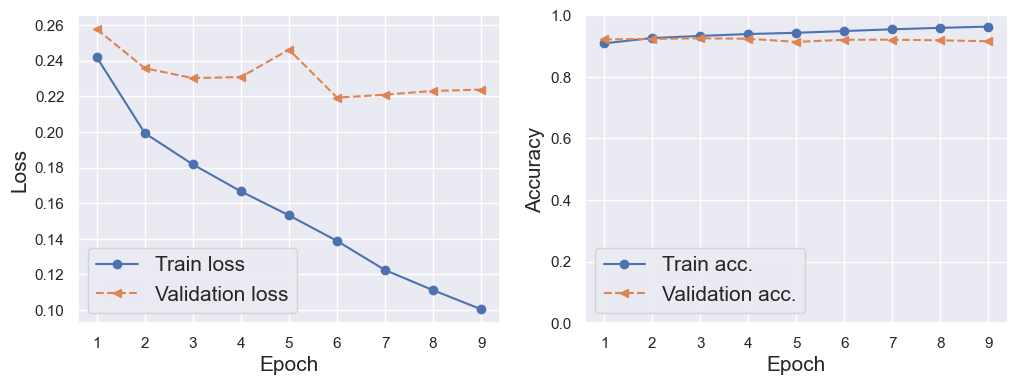

In [17]:
plot_loss_accuracy(history_cnn_1)

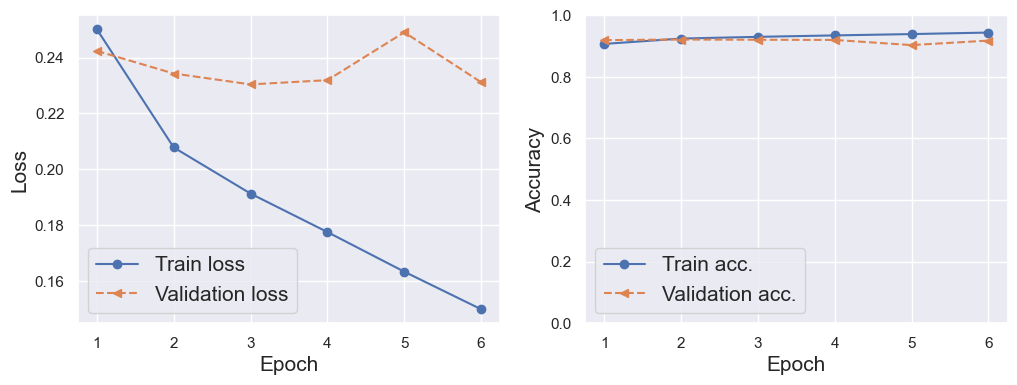

In [18]:
plot_loss_accuracy(history_cnn_2)

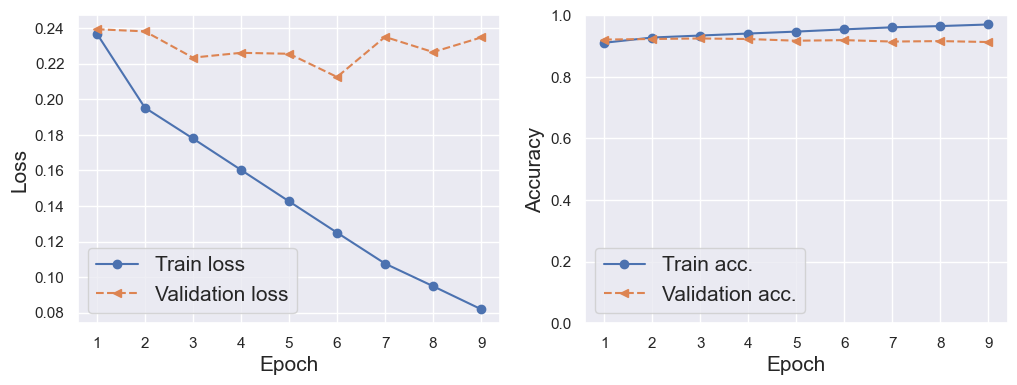

In [19]:
plot_loss_accuracy(history_cnn_3)

In [32]:
#Use model with the lowest validation loss
model_cnn = tf.keras.models.load_model("model_cnn_1.keras")

In [ ]:
#Translate each word to their respective word embedding 
X_train_cnn_embedded = []
embeddings_lookup = model_cnn.layers[0].get_weights()[0]
#For each sentence 
for i in range(X_train_reduced2.shape[0]):
    #Lookup the coded word in the embeddings matrix and concatenate each word into a list
    embedding_row = list(pd.Series(X_train_reduced2[i]).apply(lambda x: list(embeddings_lookup[x])).values)
    X_train_cnn_embedded.append(embedding_row)
X_train_cnn_embedded = np.array(X_train_cnn_embedded)
    

In [ ]:
X_val_cnn_embedded = []

for i in range(X_val_reduced2.shape[0]):
    embedding_row = list(pd.Series(X_val_reduced2[i]).apply(lambda x: list(embeddings_lookup[x])).values)
    X_val_cnn_embedded.append(embedding_row)
X_val_cnn_embedded = np.array(X_val_cnn_embedded)
    

In [ ]:
X_test_cnn_embedded = []

for i in range(X_test_reduced2.shape[0]):
    embedding_row = list(pd.Series(X_test_reduced2[i]).apply(lambda x: list(embeddings_lookup[x])).values)
    X_test_cnn_embedded.append(embedding_row)
X_test_cnn_embedded = np.array(X_test_cnn_embedded)
    

In [ ]:
with open('embeddings_cnn_trained.pkl', 'wb') as handle:
    pickle.dump(embeddings_lookup, handle)
with open('X_train_cnn_word_embedded.pkl', 'wb') as handle:
    pickle.dump(X_train_cnn_embedded, handle)
with open('X_val_cnn_word_embedded.pkl', 'wb') as handle:
    pickle.dump(X_val_cnn_embedded, handle)
with open('X_test_word_cnn_embedded.pkl', 'wb') as handle:
    pickle.dump(X_test_cnn_embedded, handle)

### Embedding Prediction Analysis

In [20]:
#Use model with the lowest validation loss
model_cnn = tf.keras.models.load_model("model_cnn_1.keras")

In [34]:
model_we_predictions = np.round(model.predict(X_train_reduced2)).flatten().astype(int)
model_cnn_predictions = np.round(model_cnn.predict(X_train_reduced2)).flatten().astype(int)


4352/4352 [==============================] - 32s 7ms/step


In [172]:
model_we_val_pred = np.round(model.predict(X_val_reduced2)).flatten().astype(int)
model_cnn_val_pred = np.round(model_cnn.predict(X_val_reduced2)).flatten().astype(int)


1451/1451 [==============================] - 12s 8ms/step


In [173]:
train_results = pd.DataFrame({"Actual": y_train, 
                             "Word Embedding": model_we_predictions,
                             "1D CNN": model_cnn_predictions})
val_results = pd.DataFrame({"Actual": y_val,
                           "Word Embedding": model_we_val_pred,
                           "1D CNN": model_cnn_val_pred})

In [60]:
#Training
we_equal_cnn = round(train_results[train_results["Word Embedding"] == train_results["1D CNN"]].shape[0]/train_results.shape[0] * 100, 2)
we_equal_cnn_both_correct = round(train_results[(train_results["Word Embedding"] == train_results["1D CNN"]) & 
                                                (train_results["Word Embedding"] == train_results["Actual"])].shape[0]/train_results.shape[0] * 100, 2)
we_equal_cnn_both_incorrect = round(train_results[(train_results["Word Embedding"] == train_results["1D CNN"]) & 
                                                  (train_results["Word Embedding"] != train_results["Actual"])].shape[0]/train_results.shape[0] * 100, 2)
we_nequal_cnn_we_correct = round(train_results[(train_results["Word Embedding"] != train_results["1D CNN"]) & 
                                              (train_results["Word Embedding"] == train_results["Actual"])].shape[0]/train_results.shape[0] * 100, 2) 
we_nequal_cnn_cnn_correct = round(train_results[(train_results["Word Embedding"] != train_results["1D CNN"]) & 
                                              (train_results["1D CNN"] == train_results["Actual"])].shape[0]/train_results.shape[0] * 100, 2)
either_correct = we_equal_cnn_both_correct + we_nequal_cnn_we_correct + we_nequal_cnn_cnn_correct

print("% Word Embedding = 1D CNN:", we_equal_cnn)
print("% Word Embedding = 1D CNN and Correct:", we_equal_cnn_both_correct)
print("% Word Embedding = 1D CNN and Incorrect:", we_equal_cnn_both_incorrect)
print("% Word Embedding != 1D CNN, Word Embedding Correct:", we_nequal_cnn_we_correct)
print("% Word Embedding != 1D CNN, 1D CNN Correct:", we_nequal_cnn_cnn_correct)
print("% Either Word Embedding or 1D CNN Correct:", either_correct)


% Word Embedding = 1D CNN: 95.53
% Word Embedding = 1D CNN and Correct: 92.36
% Word Embedding = 1D CNN and Incorrect: 3.17
% Word Embedding != 1D CNN, Word Embedding Correct: 1.09
% Word Embedding != 1D CNN, 1D CNN Correct: 3.38
% Either Word Embedding or 1D CNN Correct: 96.83


In [175]:
#Validation
we_equal_cnn = round(val_results[val_results["Word Embedding"] == val_results["1D CNN"]].shape[0]/val_results.shape[0] * 100, 2)
we_equal_cnn_both_correct = round(val_results[(val_results["Word Embedding"] == val_results["1D CNN"]) & 
                                                (val_results["Word Embedding"] == val_results["Actual"])].shape[0]/val_results.shape[0] * 100, 2)
we_equal_cnn_both_incorrect = round(val_results[(val_results["Word Embedding"] == val_results["1D CNN"]) & 
                                                  (val_results["Word Embedding"] != val_results["Actual"])].shape[0]/val_results.shape[0] * 100, 2)
we_nequal_cnn_we_correct = round(val_results[(val_results["Word Embedding"] != val_results["1D CNN"]) & 
                                              (val_results["Word Embedding"] == val_results["Actual"])].shape[0]/val_results.shape[0] * 100, 2) 
we_nequal_cnn_cnn_correct = round(val_results[(val_results["Word Embedding"] != val_results["1D CNN"]) & 
                                              (val_results["1D CNN"] == val_results["Actual"])].shape[0]/val_results.shape[0] * 100, 2)
either_correct = we_equal_cnn_both_correct + we_nequal_cnn_we_correct + we_nequal_cnn_cnn_correct

print("% Word Embedding = 1D CNN:", we_equal_cnn)
print("% Word Embedding = 1D CNN and Correct:", we_equal_cnn_both_correct)
print("% Word Embedding = 1D CNN and Incorrect:", we_equal_cnn_both_incorrect)
print("% Word Embedding != 1D CNN, Word Embedding Correct:", we_nequal_cnn_we_correct)
print("% Word Embedding != 1D CNN, 1D CNN Correct:", we_nequal_cnn_cnn_correct)
print("% Either Word Embedding or 1D CNN Correct:", either_correct)


% Word Embedding = 1D CNN: 95.08
% Word Embedding = 1D CNN and Correct: 89.65
% Word Embedding = 1D CNN and Incorrect: 5.43
% Word Embedding != 1D CNN, Word Embedding Correct: 2.7
% Word Embedding != 1D CNN, 1D CNN Correct: 2.22
% Either Word Embedding or 1D CNN Correct: 94.57000000000001


In [176]:
both_incorrect_index = np.where((model_we_predictions == model_cnn_predictions) & (model_we_predictions != y_train))[0]
we_incorrect_cnn_correct_index = np.where((model_we_predictions != model_cnn_predictions) & (model_cnn_predictions == y_train))[0]
both_incorrect_index_val = np.where((model_we_val_pred == model_cnn_val_pred) & (model_we_val_pred != y_val))[0]
we_incorrect_cnn_correct_index_val = np.where((model_we_val_pred != model_cnn_val_pred) & (model_cnn_val_pred == y_val))[0]




In [178]:
train_df = pd.DataFrame({"Text": X_train, 
                        "Label": y_train}).reset_index()
val_df = pd.DataFrame({"Text": X_val,
                      "Label": y_val}).reset_index()

In [96]:
print(train_df["Label"][both_incorrect_index].value_counts(normalize = True))
# Of examples both models predicted incorrectly, equally split between classes
print(train_df["Label"][we_incorrect_cnn_correct_index].value_counts(normalize = True))
# Of the examples that 1D CNN predicts correctly that word embedding predicts incorrectly, 
# 1D CNN predicts suicide class very slightly better 

Label
1    0.504304
0    0.495696
Name: proportion, dtype: float64
Label
1    0.554681
0    0.445319
Name: proportion, dtype: float64


In [179]:
print(val_df["Label"][both_incorrect_index_val].value_counts(normalize = True))
# Of examples both models predicted incorrectly, equally split between classes
print(val_df["Label"][we_incorrect_cnn_correct_index_val].value_counts(normalize = True))
# Of the examples that 1D CNN predicts correctly that word embedding predicts incorrectly, 
# 1D CNN predicts suicide class very slightly better 

Label
1    0.518048
0    0.481952
Name: proportion, dtype: float64
Label
1    0.5742
0    0.4258
Name: proportion, dtype: float64


In [159]:
index = 128236
print("Index:", index)
print("DataFrame Index:", train_df["index"][index])
print("Label:", train_df["Label"][index])
print("Text:", train_df["Text"][index])

Index: 128236
DataFrame Index: 4109
Label: 1
Text: fell belong fell fit want skunk


Incorrect predictions 

0: 

- 42236/40879: head literally ugly look no joke want blow head shotgun 
    - (blow head with shotgun)
    - Orig: 'My head is literally so ugly it looks like this no joke🗿 i want to blow my head with a shotgun so badly'
- 2239/198256: done know last day stupid going going end tomorrow feeling tired barely keep eye sleeping yesterday feeling much wanted nothing anyone tell 
    - (going end tomorrow) (processing error)
    - Orig: 'i dont know what to do for the last few days my stupid exams have been going on. its gonna end tomorrow. im feeling super tired and i can barely keep my eyes open. its not like im not sleeping. yesterday i was not feleing much and i just wanted to do nothing. can anyone tell me why?'
- 70317/218205: remember important help someone depression willing help tried never worked always look number number way andlt
    - (depression)
    - Orig: 'Remember this it’s important You can’t help someone’s depression if they aren’t willing to help themselves. I’ve tried and it never worked and it just stressed me out. Always look out for number one (number one is you btw &lt;3)'
- 137796/145157: laugh loudly need help writing something girlfriend know best place birthday tomorrow want write something nice silence put feeling word help
    - (need help with girlfriend)
    - Orig: 'Ya’ll i need some help writing something for my girlfriend 😭 Ik this may not be the BEST place for this but- Its her birthday tomorrow and i want to write something nice for her... i just cant put my feelings into words. Help? 💀'
- 53179/31674: feeling bit need someone talk feeling need someone talk
    - (need someone to talk with)
    - Orig: 'Feeling a bit down, need someone to talk to Not feeling too great now, just need someone to talk to for a while.'
    
1:
- 124201/44769: want text person relationship first girlfriend dated month september birthday thanksgiving left worst term possible feel text anyways ism lonely know wish get drunk alone something help
    - (breakup with girlfriend, got drunk, need help)
    - Orig: 'I wanna text my exShe the only person I was in a relationship with, she was my first girlfriend. We dated for 2 months back in 2015 from September 15th my bday) to Thanksgiving \n\nWe left on the worst terms possible \n\nBut I just feel like I should text her anyways because I’m so lonely \n\nIdk\n\nI wish I could get drunk alone or something\n\nHelp'
- 27809/105939: miss gone list something miss close eye loudly start miss listening astr video youtube falling listening favourite astr whisper artist
    - (miss falling asleep listening to favorite whisper youtube)
    - Orig: "What would you miss when you're gone?List something you would miss when you close your eyes forever. I'll start. I would miss listening to ASMR videos on youtube. And falling asleep listening to my favorite ASMR whisper artists."
- 123220/50660: never felt lonely entire life right girlfriend currently left second time made silence
    - (never feel lonely, right girlfriend) (due to processing)
    - Orig: 'By myself.I’ve never felt more lonely in my entire life than I do right now. My gf currently left me for the second time and it just made me worse....'
- 117775/38727: help anyone age free open frank conversation mind please
    - (needs help and wants a conversation)
    - Orig: 'HelpAnyone (preferably over the age of 35) free for an open and frank conversation via DM please?'
- 128236/4109: fell belong fell fit want skunk
    - gibberish 
    - Orig: "I fell like im don't belong hereI fell like im don't fit in there. I only want to be skunk"
